# ИП Веревкин — предобработка и анализ данных

**Описание:**

В нашем распоряжении находятся обезличенные данные о пользователях компании ReviewLab. База данных включает информацию о:

* линейке тарифов
* профиле пользователей
* совершенных покупках
* пользовательских виджетах и их настройках

Данные предоставлены в рамках Мастерской Яндекс Практикума. Проект имеет реальную бизнес-задачу, с реальным заказчиком. Результаты работы будут проходить экспертную оценку.

**Цель проекта:**

Провести анализ исторических данных компании ReviewLab (разработчика виджетов для агрегации отзывов с различных платформ) с целью выдвижения гипотез по оптимизации линейки тарифов.

**Ключевые этапы проекта:**

1. Предобработка данных:
    * Анализ пропущенных значений
    * Преобразование данных
    * Анализ дубликатов
    * Исследование аномалий
2. Исследовательский анализ    
    * Исследование распределений признаков
3. Финансовый анализ
    * Расчёт Conversion Rate
    * Расчёт и визуализация квартального ARPPU по тарифам
    * Расчёт и визуализация:
        * среднего чека за квартал (средняя выручка за покупку)
        * общей квартальной выручки компании
4. Статистический анализ
    * Проверка гипотезы о различии выбранных тарифов между компаниями с большим и малым количеством отзывов.
5. Сравнение тарифных линеек конкурентов
6. Разработка рекомендаций
7. Подготовка отчёта

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import missingno as msno
import numpy as np
from scipy import stats as st
import statsmodels.api as sm
import plotly.express as px
from statsmodels.iolib.table import SimpleTable
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#plt.style.use('dark_background')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sns.set_style("whitegrid")
#sns.set_style("darkgrid")

In [3]:
antique = ['#855C75FF', '#D9AF6BFF', '#AF6458FF', '#736F4CFF', '#526A83FF', '#625377FF',
           '#68855CFF', '#9C9C5EFF', '#A06177FF', '#8C785DFF', '#467378FF', '#7C7C7CFF']

capitol_reef = ['#291919FF', '#532A34FF', '#7C5467FF', '#878195FF', '#AEB2B7FF', '#D4D9DDFF']

kiwi = ['#3E2926FF', '#634C54FF', '#8B7162FF', '#A9A196FF', '#CFAE9FFF', '#D3BAC0FF']

er_whole = ['#53505AFF', '#495564FF', '#5C616FFF', '#B5BCCBFF', '#DCDCE3FF']

In [4]:
sns.set_palette(antique)

In [6]:
with open(r"/content/payments.json", encoding='utf-8') as f:
    data = json.load(f)

df_payments = pd.json_normalize(data)

with open(r"/content/plans.json", encoding='utf-8') as f:
    data = json.load(f)

df_plans = pd.json_normalize(data)

with open(r"/content/widgets.json", encoding='utf-8') as f:
    data = json.load(f)

df_widgets = pd.json_normalize(data)

with open(r"/content/users-26.03.25.json", encoding='utf-8') as f:
    data = json.load(f)

df_users = pd.json_normalize(data)

## Подготовка данных

### Анализ пропусков

Визуализируем пропуски по колонкам

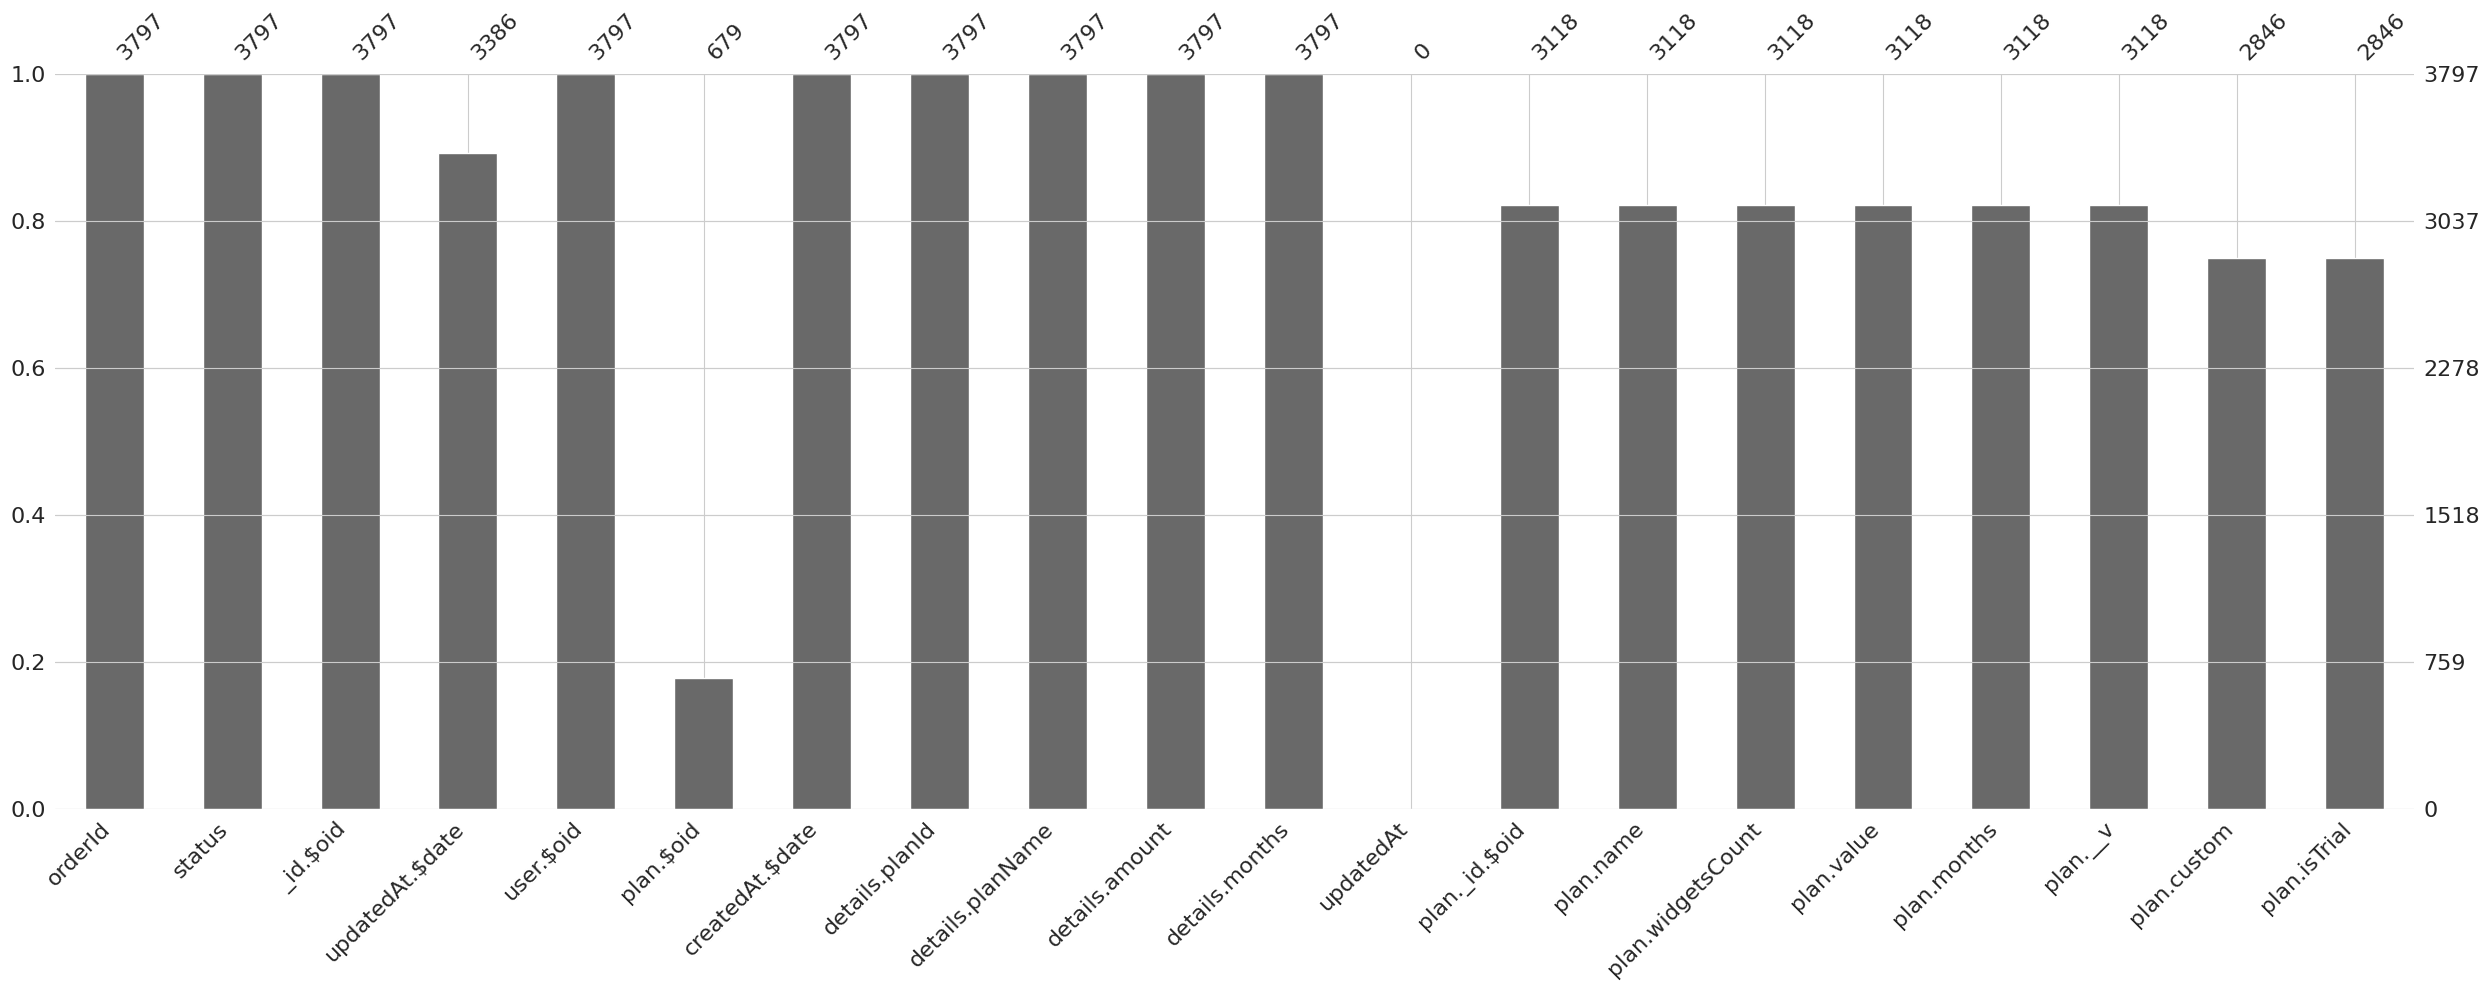

In [7]:
msno.bar(df_payments)

plt.tight_layout()
plt.show()

Посмотрим на расположение пропусков в строках

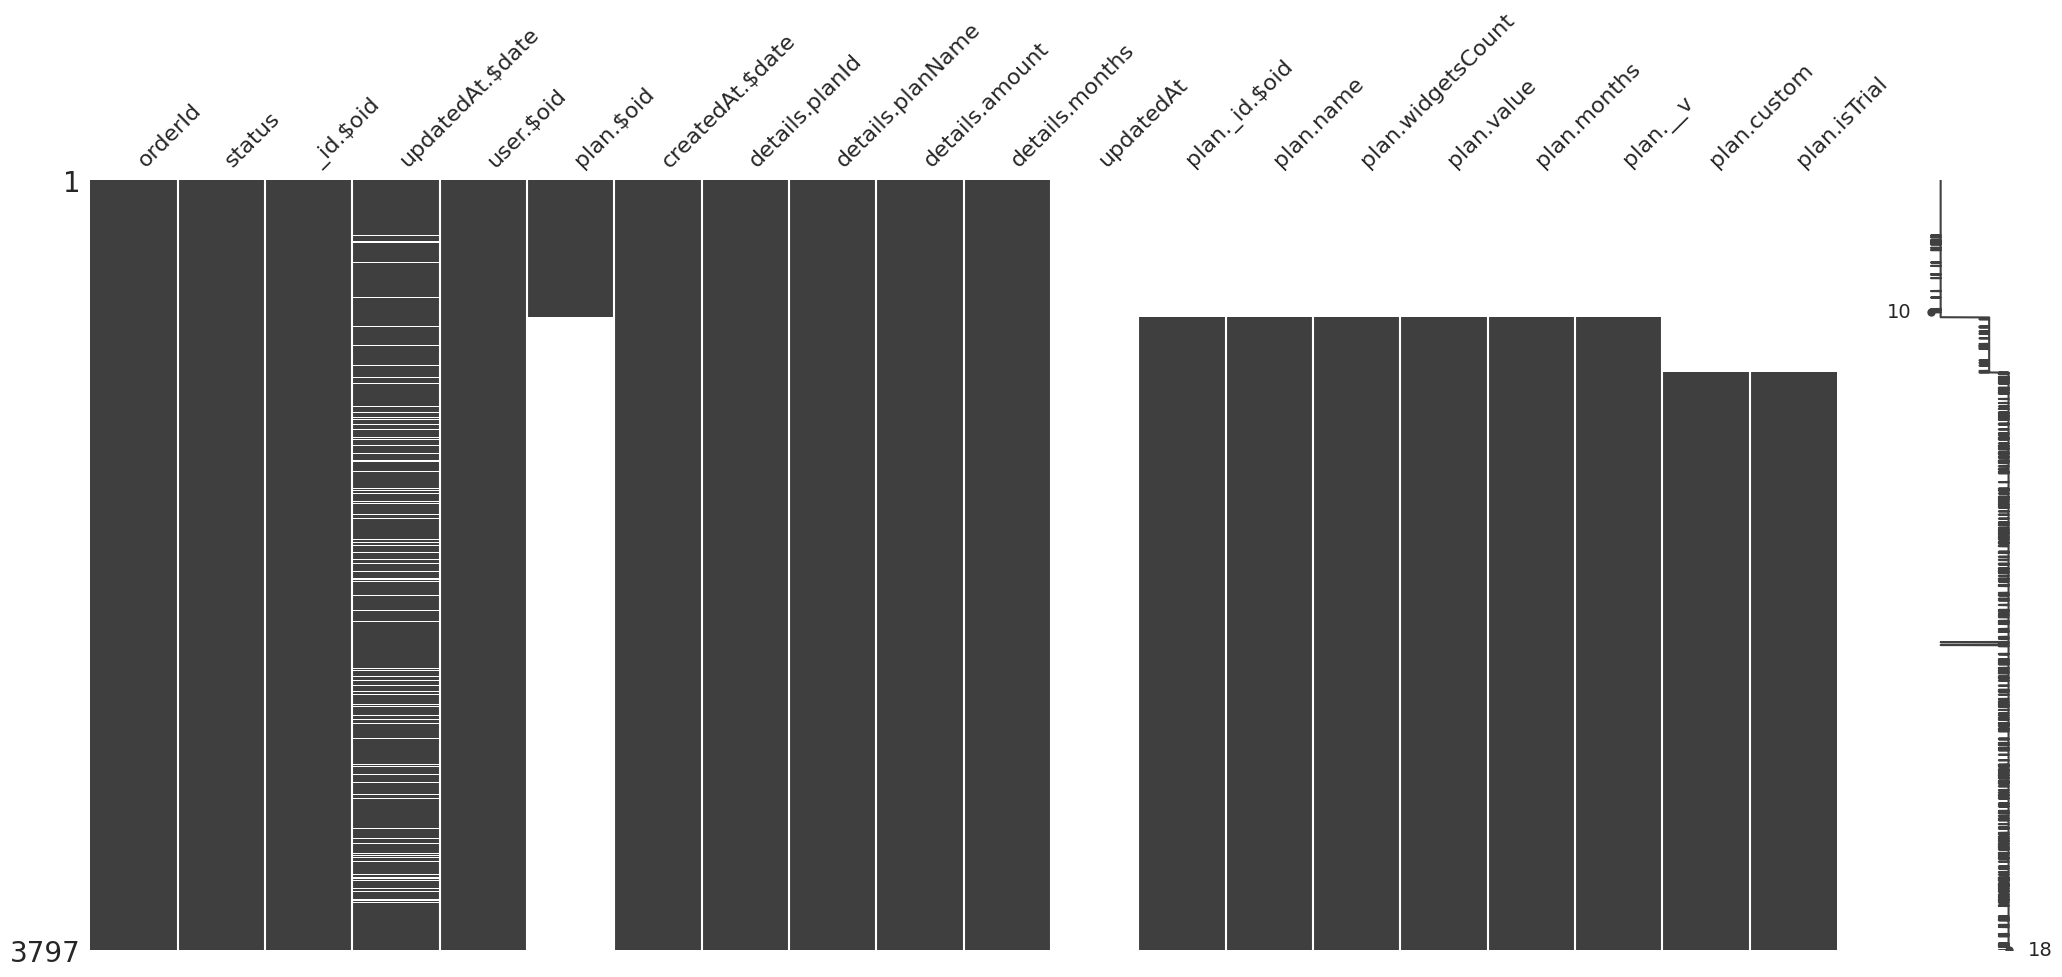

In [8]:
msno.matrix(df_payments)

plt.show()

In [9]:
missing_pay = (
    df_payments.isnull().sum() / df_payments.shape[0] * 100
    ).round(2).sort_values(
        ascending=False).copy().reset_index().rename(columns={
            'index': 'feature',
            0: 'missing'}
          ).query('missing > 0')

In [10]:
missing_pay['missing'] = missing_pay['missing'].apply(lambda x: str(x) + '%')
missing_pay

feature missing
0           updatedAt  100.0%
1           plan.$oid  82.12%
2         plan.custom  25.05%
3        plan.isTrial  25.05%
4            plan.__v  17.88%
5         plan.months  17.88%
6   plan.widgetsCount  17.88%
7          plan.value  17.88%
8           plan.name  17.88%
9       plan._id.$oid  17.88%
10    updatedAt.$date  10.82%

**Вывод:**

* Поле `updatedAt` полностью пустое и не несёт смысловой нагрузки — его следует удалить.
* Поля `plan.$oid` и `plan._id.$oid`, судя по всему, являются частью друг друга. Объединим их в одно.
* В поле `updatedAt.$date` пропуски распределены случайным образом по строкам, их доля составляет 10.82%.
* В датафрейме есть поля из таблицы df_plans, в которых содержится 17.88%-25.05% пропусков.

Строки с пропусками удалить мы не можем, потому что потеряем большую часть данных. Если поля, которые имеют префикс plan являются дубликатами таблицы plans, то удалим их.

In [11]:
df_payments.drop(columns=['updatedAt'], axis=1, inplace=True)

In [12]:
df_payments['plan_id'] = df_payments['plan.$oid'].combine_first(df_payments['plan._id.$oid'])
df_payments.drop(columns=['plan.$oid', 'plan._id.$oid'], axis=1, inplace=True)

In [13]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797 entries, 0 to 3796
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   orderId            3797 non-null   object 
 1   status             3797 non-null   object 
 2   _id.$oid           3797 non-null   object 
 3   updatedAt.$date    3386 non-null   object 
 4   user.$oid          3797 non-null   object 
 5   createdAt.$date    3797 non-null   object 
 6   details.planId     3797 non-null   object 
 7   details.planName   3797 non-null   object 
 8   details.amount     3797 non-null   int64  
 9   details.months     3797 non-null   int64  
 10  plan.name          3118 non-null   object 
 11  plan.widgetsCount  3118 non-null   float64
 12  plan.value         3118 non-null   float64
 13  plan.months        3118 non-null   float64
 14  plan.__v           3118 non-null   float64
 15  plan.custom        2846 non-null   object 
 16  plan.isTrial       2846 

В таблице присутствуют два поля, связанных с идентификаторами тарифных планов:

* `details.planId` - содержит идентификатор тарифного плана из таблицы тарифов
* `plan_id` - внешний ключ, ссылающийся на первичный ключ таблицы тарифов

Необходимо проанализировать эти поля на предмет возможных различий в их значениях.

In [14]:
(df_payments['plan_id'] != df_payments['details.planId']).sum()

np.int64(7)

In [15]:
df_payments[df_payments['details.planId'] != df_payments['plan_id']][["details.planId",
                                                                      "details.planName",
                                                                      "details.amount",
                                                                      "details.months",
                                                                      "plan.name",
                                                                      "plan.widgetsCount",
                                                                      "plan.value",
                                                                      "plan.months",
                                                                      "plan_id"]]

details.planId            details.planName  details.amount  \
60    60eac84590455c57287ec8f5               Start - 1 год            1788   
464   60eac84590455c57287ec8f5         80 виджетов - 6 мес           23600   
964   60eac72290455cce1f7ec8a4              Medium - 1 год            4650   
1187  60eac72290455cce1f7ec8a4               Start - 1 год            2100   
1439  64790b4e04ea17d8def4f19d        150 виджетов - 3 мес           26000   
2292  60eac72290455cce1f7ec8a4  Medium - 1 год - 4 виджета            1550   
2333  60eac7c090455c3f927ec8d1    Medium - 1 год (доплата)            2550   

      details.months                 plan.name  plan.widgetsCount  plan.value  \
60                12                       NaN                NaN         NaN   
464                6                       NaN                NaN         NaN   
964               12            Medium - 1 год                3.0      4650.0   
1187              12             Start - 1 год                1.0      2100.0   
1439               3             Start - 3 мес                1.0       650.0   
2292              12                       NaN                NaN         NaN   
2333              12  Medium - 1 год (доплата)                3.0      2550.0   

      plan.months                   plan_id  
60            NaN  60eac72290455cce1f7ec8a4  
464           NaN  60eac82590455caaa17ec8e9  
964          12.0  60eac7dd90455cbc467ec8d7  
1187         12.0  60eac76b90455c5d167ec8b8  
1439          3.0  60eac76b90455c5d167ec8b8  
2292          NaN  65dec5de186c28b15cf2cdc4  
2333         12.0  60eac72290455cce1f7ec8a4

In [16]:
df_plans

name  widgetsCount  value  months  __v  custom  \
0                Start - 1 год             1   2490      12    0   False   
1                Start - 3 мес             1    770       3    0   False   
2               Medium - 1 год             3   5350      12    0   False   
3               Medium - 3 мес             3   1670       3    0   False   
4               Expert - 1 год            10   9200      12    0   False   
5               Expert - 3 мес            10   2850       3    0   False   
6    Start - 1 год - 2 виджета             2   4800      12    0    True   
7                Extra - 1 год            15  13800      12    0    True   
8         150 виджетов - 3 мес           150  29500       3    0    True   
9            Expert 16 - 1 год            16  14720      12    0    True   
10  Medium - 1 год - 4 виджета             4   7200      12    0    True   
11           Expert 12 - 1 год            12  11040      12    0    True   
12            Extra - 3 месяца            15   4250       3    0    True   

    isTrial                  _id.$oid  
0     False  60eac72290455cce1f7ec8a4  
1     False  60eac76b90455c5d167ec8b8  
2     False  60eac7c090455c3f927ec8d1  
3     False  60eac7dd90455cbc467ec8d7  
4     False  60eac82590455caaa17ec8e9  
5     False  60eac84590455c57287ec8f5  
6     False  63d222d256f49c4a6af0410a  
7     False  64512a7841905e8972c8cf4d  
8     False  64790b4e04ea17d8def4f19d  
9     False  651ee3695d9bb7f812aa115d  
10    False  65dec5de186c28b15cf2cdc4  
11    False  66dee2178aade27cb3944e41  
12    False  674857fc24021fe30ea570cf

Поля `__v` и `isTrial` заполнены нулями. Удалим их, потому что они не несут никакой информации.

In [17]:
df_plans = df_plans.drop(columns=['__v', 'isTrial'], axis=1)

In [18]:
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          13 non-null     object
 1   widgetsCount  13 non-null     int64 
 2   value         13 non-null     int64 
 3   months        13 non-null     int64 
 4   custom        13 non-null     bool  
 5   _id.$oid      13 non-null     object
dtypes: bool(1), int64(3), object(2)
memory usage: 665.0+ bytes


Вероятно, идентификаторы `details.planId` указаны корректно. Предлагаю оптимизировать структуру данных следующим образом:

* Удалить все поля, содержащие префикс `plans`, так как они являются избыточными.
* Выполнить присоединение таблицы df_plans.

Также мы можем видеть, что в df_plans нет пропусков, все типы данных корректны и отсутствуют дубликаты.

In [19]:
df_payments = df_payments.loc[:, :'details.months']

In [20]:
df_payments_plans = pd.merge(df_payments, df_plans, how='inner', left_on='details.planId', right_on='_id.$oid')
df_payments_plans.head()

orderId     status                _id.$oid_x  \
0  48992013-af97-45eb-834f-5d7b4571ebc8  SUCCEEDED  60f7bb86a8f24781ffb9d8e9   
1  c9b61037-6285-4243-858f-e2aa69436e61  CANCELLED  60fa6182c1b1be872389289e   
2  82605ff3-d9a4-45fd-bd0a-bd4f13e176a6  CANCELLED  61038d1ec1b1be89628fca48   
3  723ff40a-a103-41c1-b5ed-bc8ceaf08af8  SUCCEEDED  61038d44c1b1be27258fca5c   
4  901ea285-d70c-4d31-af9c-c62eb951fc4d  CANCELLED  6104de8cc1b1be5ee990e181   

            updatedAt.$date                 user.$oid  \
0  2021-07-21T06:16:38.398Z  60a773594dafac2d272c9042   
1  2021-07-23T07:31:19.854Z  60f88c4444ec2d40eb3bed47   
2  2021-07-30T06:26:48.312Z  60fc3ac9c1b1bea2a78a82a2   
3  2021-07-30T05:26:20.734Z  60fc3ac9c1b1bea2a78a82a2   
4  2021-07-31T05:25:35.096Z  60a2056e4dafac2d272c903a   

            createdAt.$date            details.planId details.planName  \
0  2021-07-21T06:15:34.993Z  60eac72290455cce1f7ec8a4    Start - 1 год   
1  2021-07-23T06:28:18.274Z  60eac72290455cce1f7ec8a4    Start - 1 год   
2  2021-07-30T05:24:46.708Z  60eac72290455cce1f7ec8a4    Start - 1 год   
3  2021-07-30T05:25:24.959Z  60eac72290455cce1f7ec8a4    Start - 1 год   
4  2021-07-31T05:24:28.405Z  60eac72290455cce1f7ec8a4    Start - 1 год   

   details.amount  details.months           name  widgetsCount  value  months  \
0            1788              12  Start - 1 год             1   2490      12   
1            1788              12  Start - 1 год             1   2490      12   
2            1788              12  Start - 1 год             1   2490      12   
3            1788              12  Start - 1 год             1   2490      12   
4            1788              12  Start - 1 год             1   2490      12   

   custom                _id.$oid_y  
0   False  60eac72290455cce1f7ec8a4  
1   False  60eac72290455cce1f7ec8a4  
2   False  60eac72290455cce1f7ec8a4  
3   False  60eac72290455cce1f7ec8a4  
4   False  60eac72290455cce1f7ec8a4

Таким же образом проверим пропуски в таблице df_widgets.

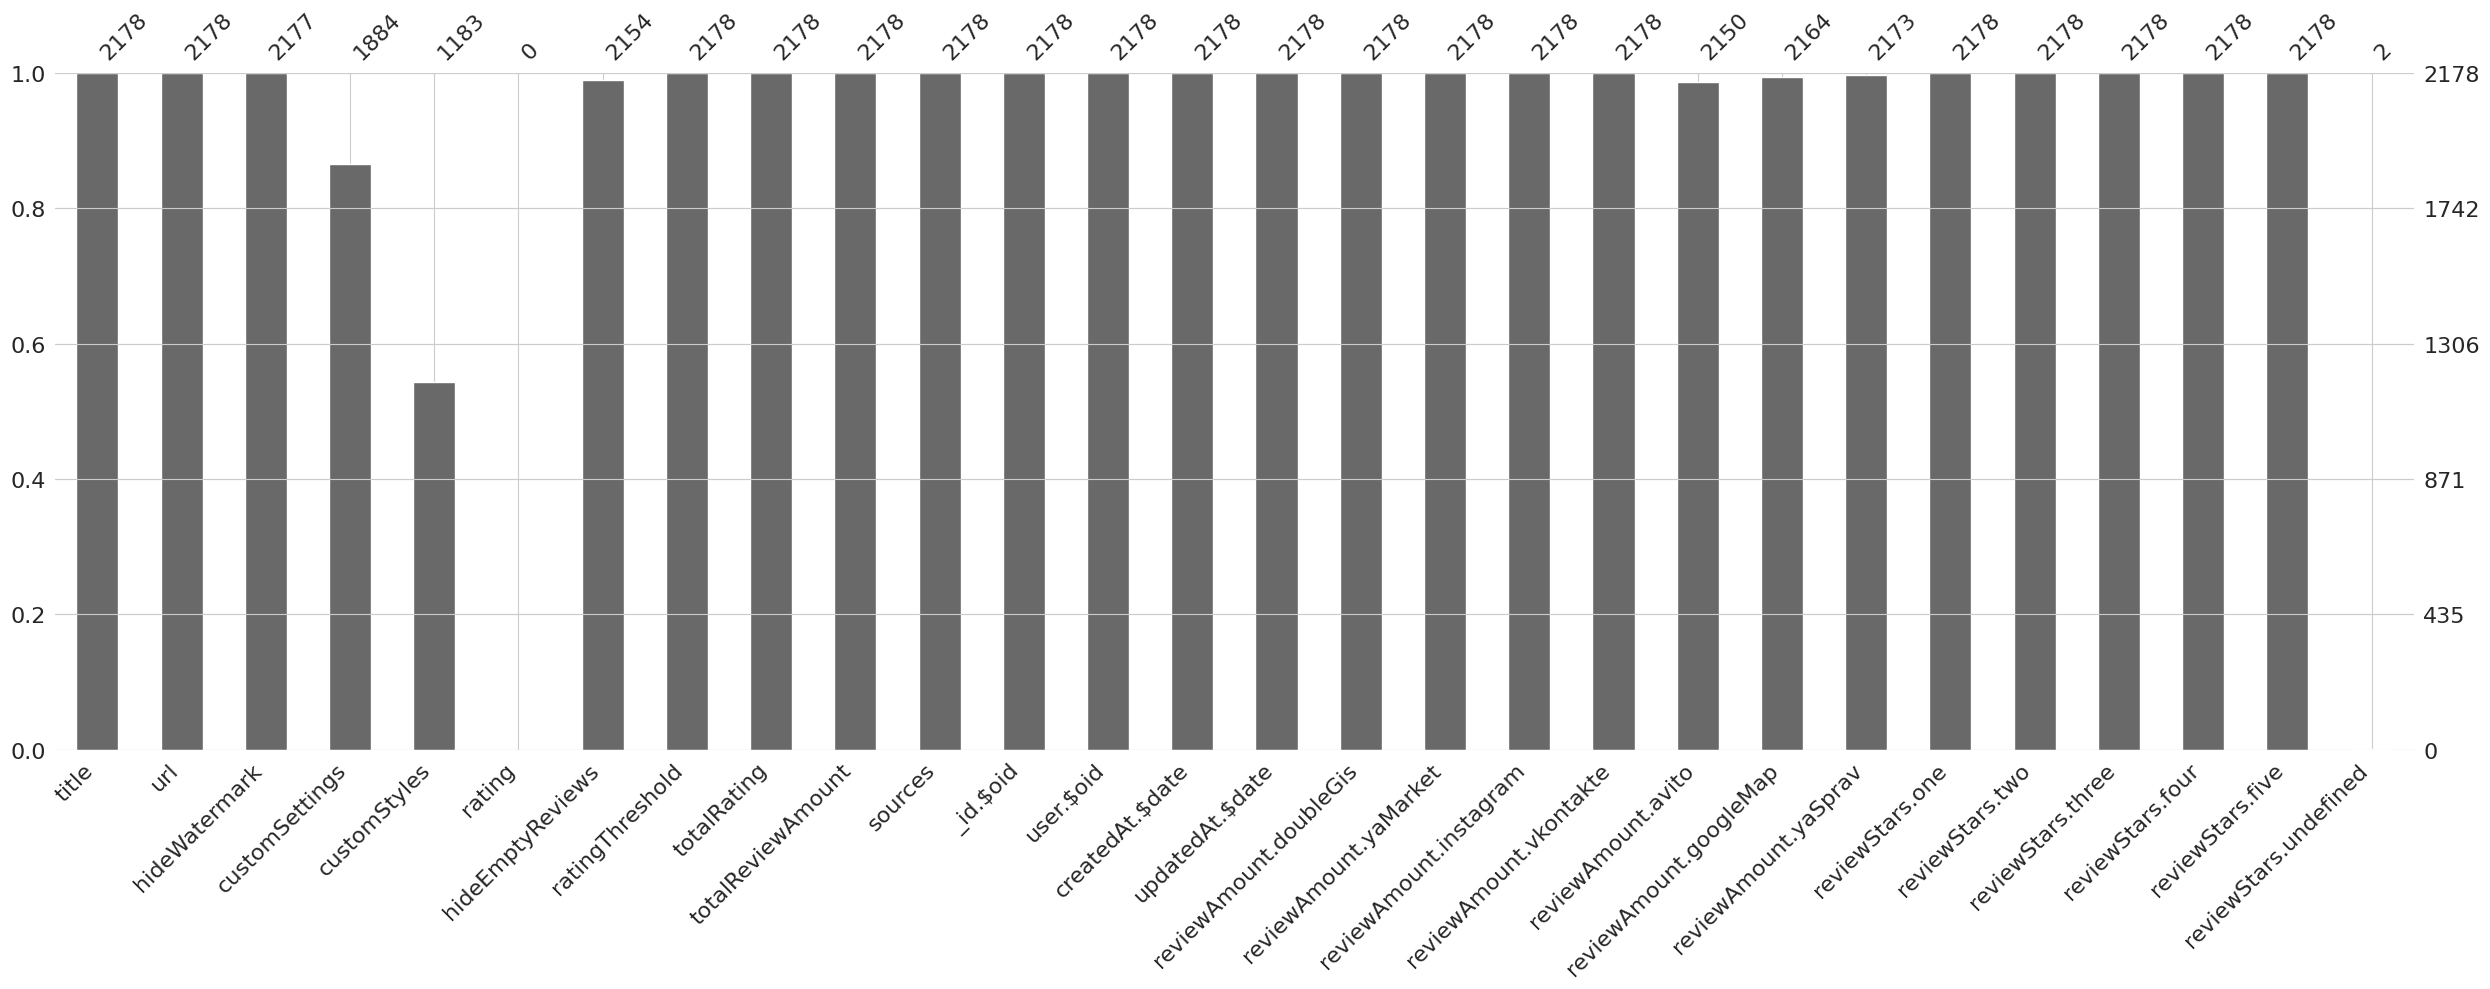

In [21]:
msno.bar(df_widgets)

plt.tight_layout()
plt.show()

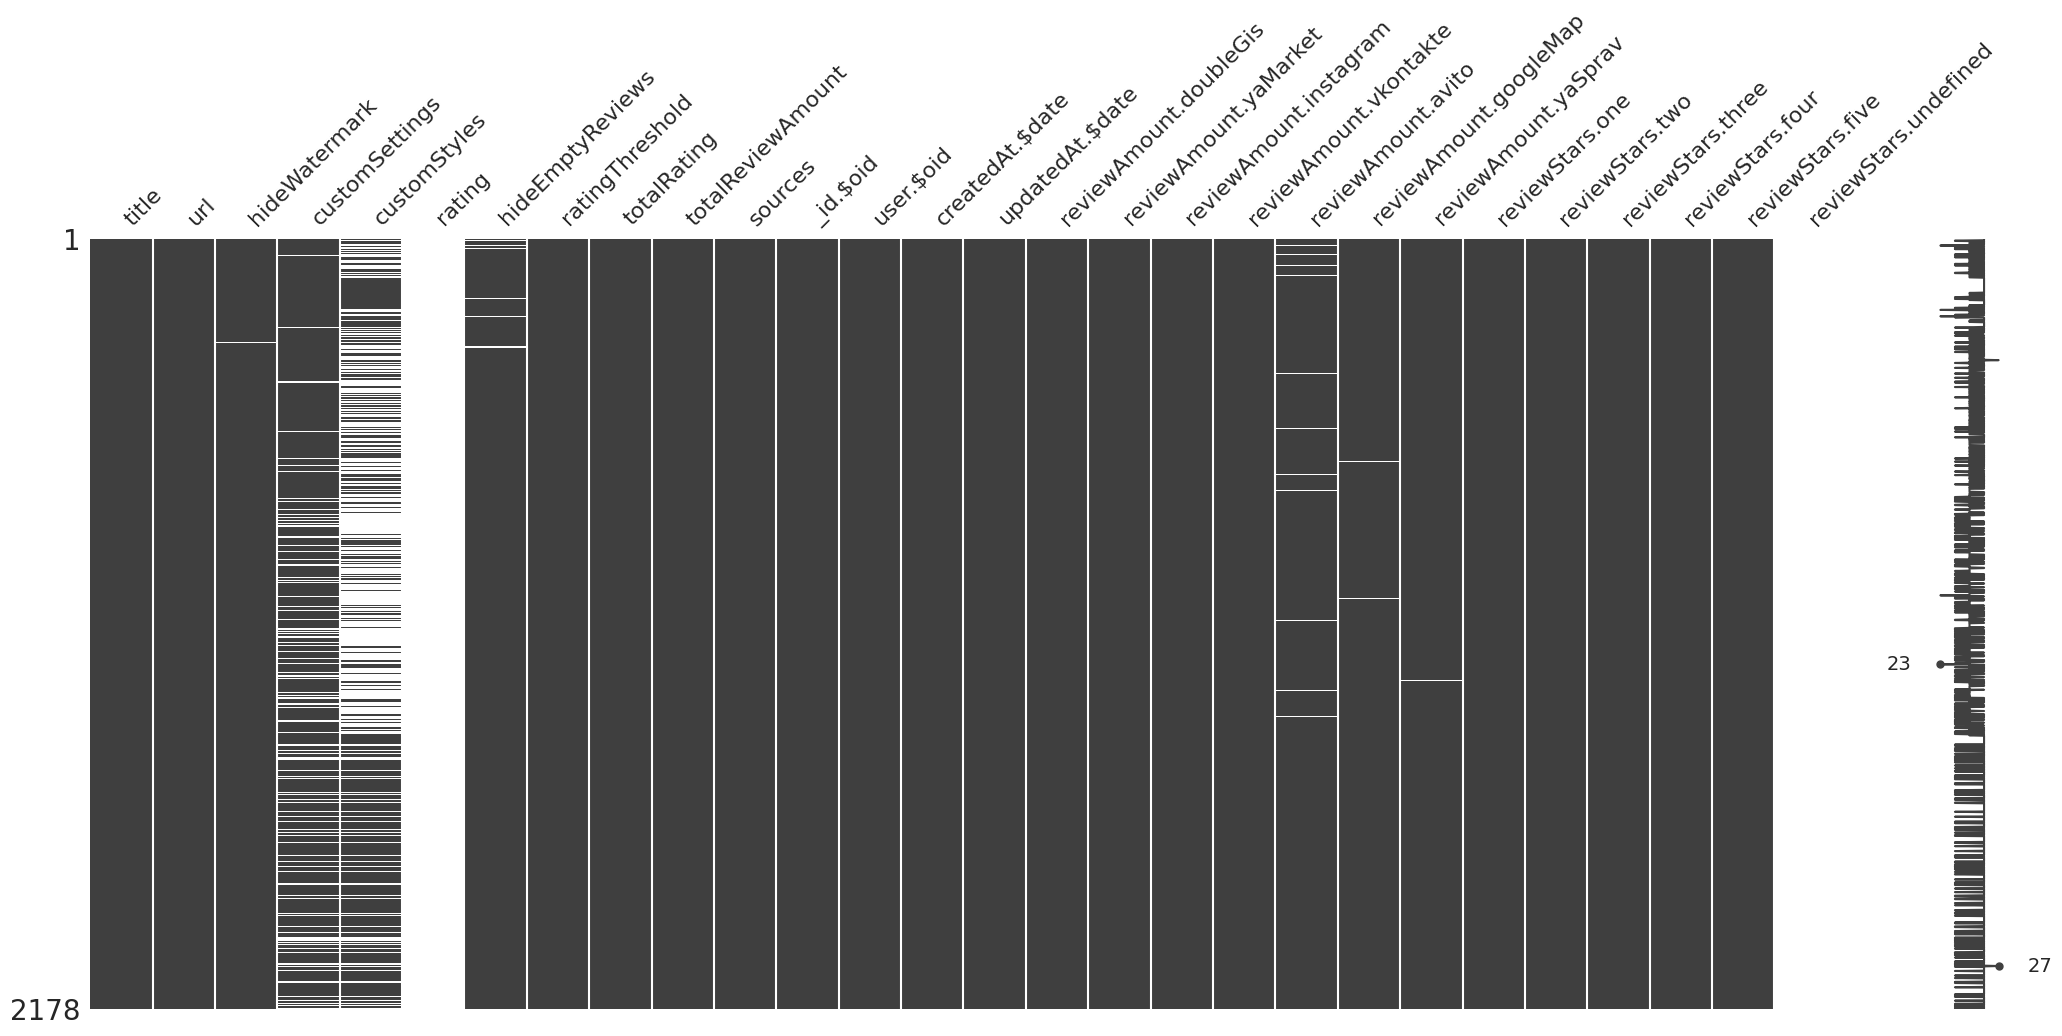

In [22]:
msno.matrix(df_widgets)

plt.show()

In [23]:
missing_wid = (
    df_widgets.isnull().sum() / df_widgets.shape[0] * 100
    ).round(2).sort_values(
        ascending=False).copy().reset_index().rename(columns={
            'index': 'feature',
            0: 'missing'}
          ).query('missing > 0')

In [24]:
missing_wid['missing'] = missing_wid['missing'].apply(lambda x: str(x) + '%')
missing_wid

feature missing
0                  rating  100.0%
1   reviewStars.undefined  99.91%
2            customStyles  45.68%
3          customSettings   13.5%
4      reviewAmount.avito   1.29%
5        hideEmptyReviews    1.1%
6  reviewAmount.googleMap   0.64%
7    reviewAmount.yaSprav   0.23%
8           hideWatermark   0.05%

In [25]:
df_widgets.sample(2)

title                       url hideWatermark customSettings  \
1444  Отзывы яндекс  https://bestlightspb.ru/         False            NaN   
923            eeee       https://waymorr.ru/         False            NaN   

     customStyles  rating hideEmptyReviews  ratingThreshold  totalRating  \
1444          NaN     NaN            False                0          5.0   
923           NaN     NaN            False                0          4.9   

      totalReviewAmount  \
1444                 49   
923                  50   

                                                                                                                                                                                                                                  sources  \
1444                                                  [{'url': 'https://yandex.ru/profile/61616539496', 'type': 'yaSprav', 'updatedAt': {'$date': '2024-08-24T12:05:57.357Z'}, 'lastAttemptedAt': {'$date': '2024-08-24T12:05:57.357Z'}}]   
923   [{'url': 'https://yandex.ru/maps/org/waymorr/39016942329/reviews/?ll=37.576077%2C55.772612&z=15', 'type': 'yaSprav', 'updatedAt': {'$date': '2024-03-29T07:02:21.734Z'}, 'lastAttemptedAt': {'$date': '2024-03-29T07:02:21.734Z'}}]   

                      _id.$oid                 user.$oid  \
1444  66b9e8ed18144e47a76766f8  66b9e8a018144ee1b267637f   
923   65f68faa12a884579037cf6b  65f68f6712a88497f437cdaa   

               createdAt.$date           updatedAt.$date  \
1444  2024-08-12T10:50:21.392Z  2024-08-24T12:05:57.358Z   
923   2024-03-17T06:37:30.603Z  2024-03-29T07:02:21.735Z   

      reviewAmount.doubleGis  reviewAmount.yaMarket  reviewAmount.instagram  \
1444                       0                      0                       0   
923                        0                      0                       0   

      reviewAmount.vkontakte  reviewAmount.avito  reviewAmount.googleMap  \
1444                       0                 0.0                     0.0   
923                        0                 0.0                     0.0   

      reviewAmount.yaSprav  reviewStars.one  reviewStars.two  \
1444                  49.0                3                0   
923                   50.0                3                2   

      reviewStars.three  reviewStars.four  reviewStars.five  \
1444                  0                 1                45   
923                   0                 0                39   

      reviewStars.undefined  
1444                    NaN  
923                     NaN

У нас имеются два полностью пустых поля — `rating` и `reviewStars.undefined,` — которые следует удалить.

Поле `customStyles` содержит около 45% пропущенных значений. Вероятнее всего, их отсутствие означает, что пользователь использовал стандартный CSS стиль. Аналогичная ситуация наблюдается в поле `customSettings`, где пропущено 13.5% значений — скорее всего, это также говорит об использовании настроек по умолчанию.

Так как сами значения нам не особенно важны, предлагаю заменить эти поля на булевые индикаторы: True, если значение присутствует, и False, если оно отсутствует.

Остальные поля с пропусками:

* `reviewAmount.avito` — 1.29%

* `hideEmptyReviews` — 1.1%

* `reviewAmount.googleMap` — 0.64%

* `reviewAmount.yaSprav` — 0.23%

* `hideWatermark` — 0.05%

Поля `hideEmptyReviews` и `hideWatermark` являются булевыми. Скорее всего, пропуски в них можно интерпретировать как False.

Удалять строки из-за пропусков в полях с количеством отзывов по платформам нецелесообразно — доля пропусков небольшая, и это не должно повлиять на анализ. При этом удаление может привести к потере полезных данных.

In [26]:
df_widgets.drop(columns=['rating', 'reviewStars.undefined'], axis=1, inplace=True)

In [27]:
df_widgets.query('customSettings == ""')

Empty DataFrame
Columns: [title, url, hideWatermark, customSettings, customStyles, hideEmptyReviews, ratingThreshold, totalRating, totalReviewAmount, sources, _id.$oid, user.$oid, createdAt.$date, updatedAt.$date, reviewAmount.doubleGis, reviewAmount.yaMarket, reviewAmount.instagram, reviewAmount.vkontakte, reviewAmount.avito, reviewAmount.googleMap, reviewAmount.yaSprav, reviewStars.one, reviewStars.two, reviewStars.three, reviewStars.four, reviewStars.five]
Index: []

In [28]:
df_widgets['customSettings'] = df_widgets['customSettings'].notna().astype(int)

In [29]:
df_widgets['customSettings'].sum()

np.int64(1884)

In [30]:
df_widgets.query('customStyles == ""')

title                           url  \
3                        Amadey-print.ru  https://www.amadey-print.ru/   
7                  Риэлтор Мороз Дмитрий         https://moroz-riel.ru   
16    Отзывы о BOTANIC BAR в городе Сочи       https://botanic-bar.ru/   
22                     Parker-Russia.com     https://parker-russia.com   
27                          guitarget.ru      https://www.guitarget.ru   
...                                  ...                           ...   
2167                 Отзывы blazeexpress         https://blaze.express   
2169                    Отзывы приоритет       https://prioritet48.ru/   
2170                             Экоберу           https://ecoberu.ru/   
2172                              Яндекс            https://shplus.ru/   
2173                       NasutkivSochi              nasutkivsochi.ru   

     hideWatermark  customSettings customStyles hideEmptyReviews  \
3             True               1                         False   
7            False               1                         False   
16            True               1                         False   
22            True               1                          True   
27            True               1                          True   
...            ...             ...          ...              ...   
2167         False               1                         False   
2169         False               1                         False   
2170         False               1                         False   
2172         False               1                         False   
2173          True               1                          True   

      ratingThreshold  totalRating  totalReviewAmount  \
3                   0          5.0                299   
7                   0          5.0                 23   
16                  4          5.0                430   
22                  2          4.9               1087   
27                  5          5.0                709   
...               ...          ...                ...   
2167                0          5.0                  3   
2169                0          5.0                119   
2170                4          4.6                 37   
2172                0          4.8                 47   
2173                5          4.8                191   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             sources  \
3                   

In [31]:
df_widgets['customStyles'] = df_widgets['customStyles'].replace(['', 'none', 'None'], np.nan)
df_widgets['customStyles'] = df_widgets['customStyles'].notna().astype(int)

In [32]:
df_widgets['customStyles'].sum()

np.int64(429)

In [33]:
df_widgets['hideEmptyReviews'] = df_widgets['hideEmptyReviews'].fillna(False).astype(bool)
df_widgets['hideWatermark'] = df_widgets['hideWatermark'].fillna(False).astype(bool)

<ipython-input-33-c53bff7acb45>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_widgets['hideEmptyReviews'] = df_widgets['hideEmptyReviews'].fillna(False).astype(bool)
<ipython-input-33-c53bff7acb45>:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_widgets['hideWatermark'] = df_widgets['hideWatermark'].fillna(False).astype(bool)


In [34]:
df_widgets.head()

title                               url  hideWatermark  \
0               Barcodium              https://barcodium.ru          False   
1       Babyshusher (old)           https://baby-shusher.ru          False   
2                     BS2           https://baby-shusher.ru          False   
3         Amadey-print.ru      https://www.amadey-print.ru/           True   
4  Отзывы приемка квартир  https://inside-remont.ru/priemka          False   

   customSettings  customStyles  hideEmptyReviews  ratingThreshold  \
0               1             1             False                4   
1               1             1             False                0   
2               1             1             False                3   
3               1             0             False                0   
4               1             0             False                4   

   totalRating  totalReviewAmount  \
0          4.8                 30   
1          4.8                200   
2          4.8                 49   
3          5.0                299   
4          5.0                 71   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sources  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    [{'url': 'https://yandex.ru/profile/235219811488', 'type': 'yaSprav', 'updatedAt': {'$date': '2025-02-10T05:00:33.086Z'}, 'lastAttemptedAt': {'$date': '2025-02-10T05:00:33.086Z'}}, {'type': 'googleMap', 'url': 'https://www.google.com/maps/place/Barcodium/@41.7166489,44.7824117,17z/data=!3m1!4b1!4m6!3m5!1s0x40447372c70940e7:0xa3266e39e8495bec!8m2!3d41.7166489!4d44.7849866!16s%2Fg%2F11s9h6_b8q?entry=ttu', 'updatedAt': {'$date': '2023-07-15T23:13:52.959Z'}, 'lastAttemptedAt': {'$date': '2023-07-15T23:13:52.959Z'}}]   
1  [{'url': 'https://yandex.ru/profile/235219811488', 'type': 'yaSprav', 'updatedAt': {'$date': '2025-02-08T07:01:34.924Z'}, 'lastAttemptedAt': {'$date': '2025-02-08T07:01:34.924Z'}}, {'type': 'googleMap', 'url': 'https://www.google.com/maps/place/Technohub+Antalya/@41.3575793,25.096224,6z/data=!4m10!1m2!2m1!1stechnohub!3m6!1s0x14c39132abcee3fd:0x9016f374753cb571!8m2!3d36.8902232!4d30.6999789!15sCgl0ZWNobm9odWJaCyIJdGVjaG5vaHVikgEQY29tcHV0ZXJf

In [35]:
df_widgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   2178 non-null   object 
 1   url                     2178 non-null   object 
 2   hideWatermark           2178 non-null   bool   
 3   customSettings          2178 non-null   int64  
 4   customStyles            2178 non-null   int64  
 5   hideEmptyReviews        2178 non-null   bool   
 6   ratingThreshold         2178 non-null   int64  
 7   totalRating             2178 non-null   float64
 8   totalReviewAmount       2178 non-null   int64  
 9   sources                 2178 non-null   object 
 10  _id.$oid                2178 non-null   object 
 11  user.$oid               2178 non-null   object 
 12  createdAt.$date         2178 non-null   object 
 13  updatedAt.$date         2178 non-null   object 
 14  reviewAmount.doubleGis  2178 non-null   

Проверим последний датафрейм на наличие пропусков и перейдём к стандартизации названий колонок

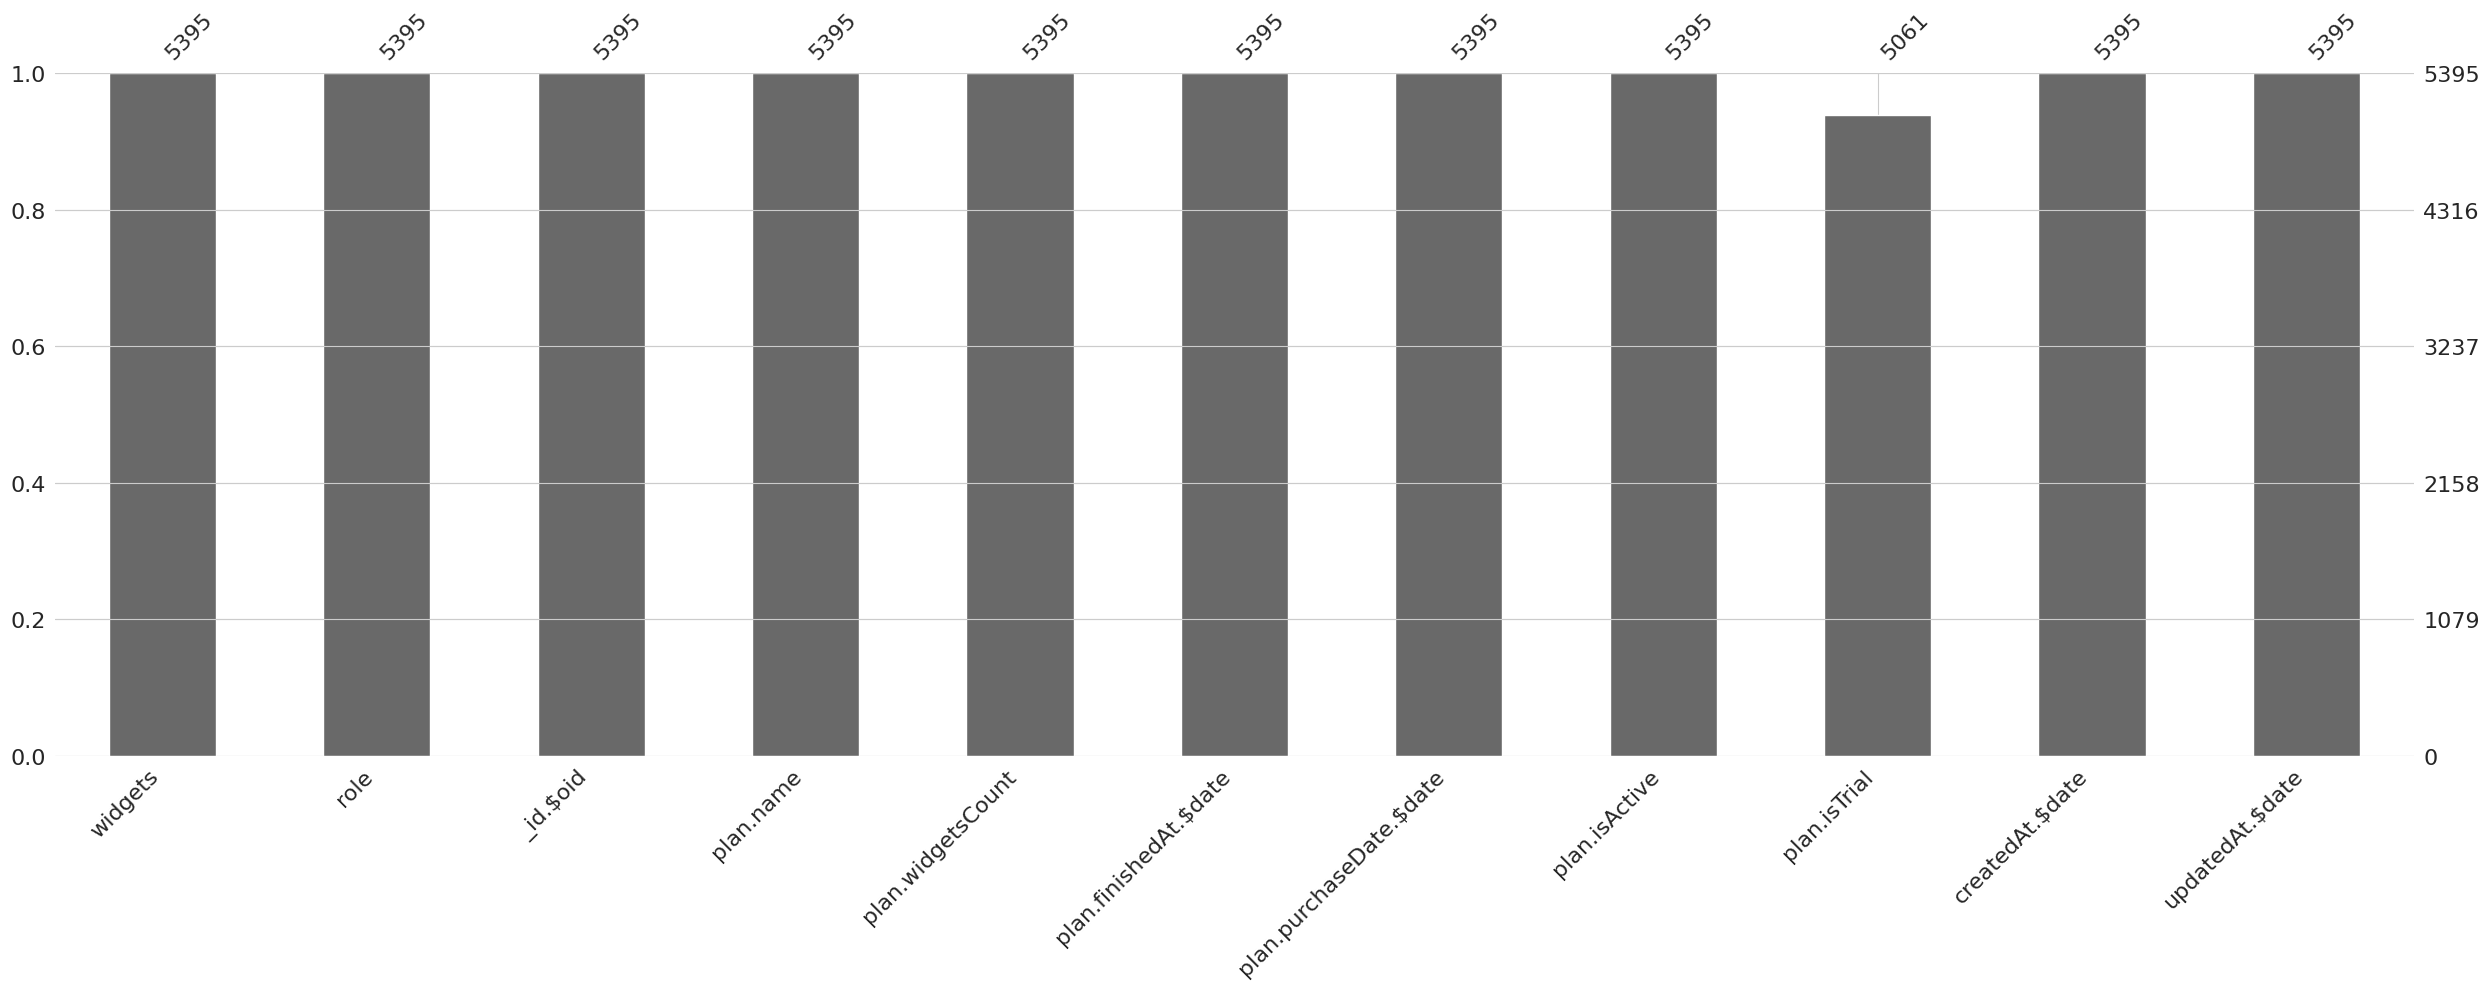

In [36]:
msno.bar(df_users)

plt.tight_layout()
plt.show()

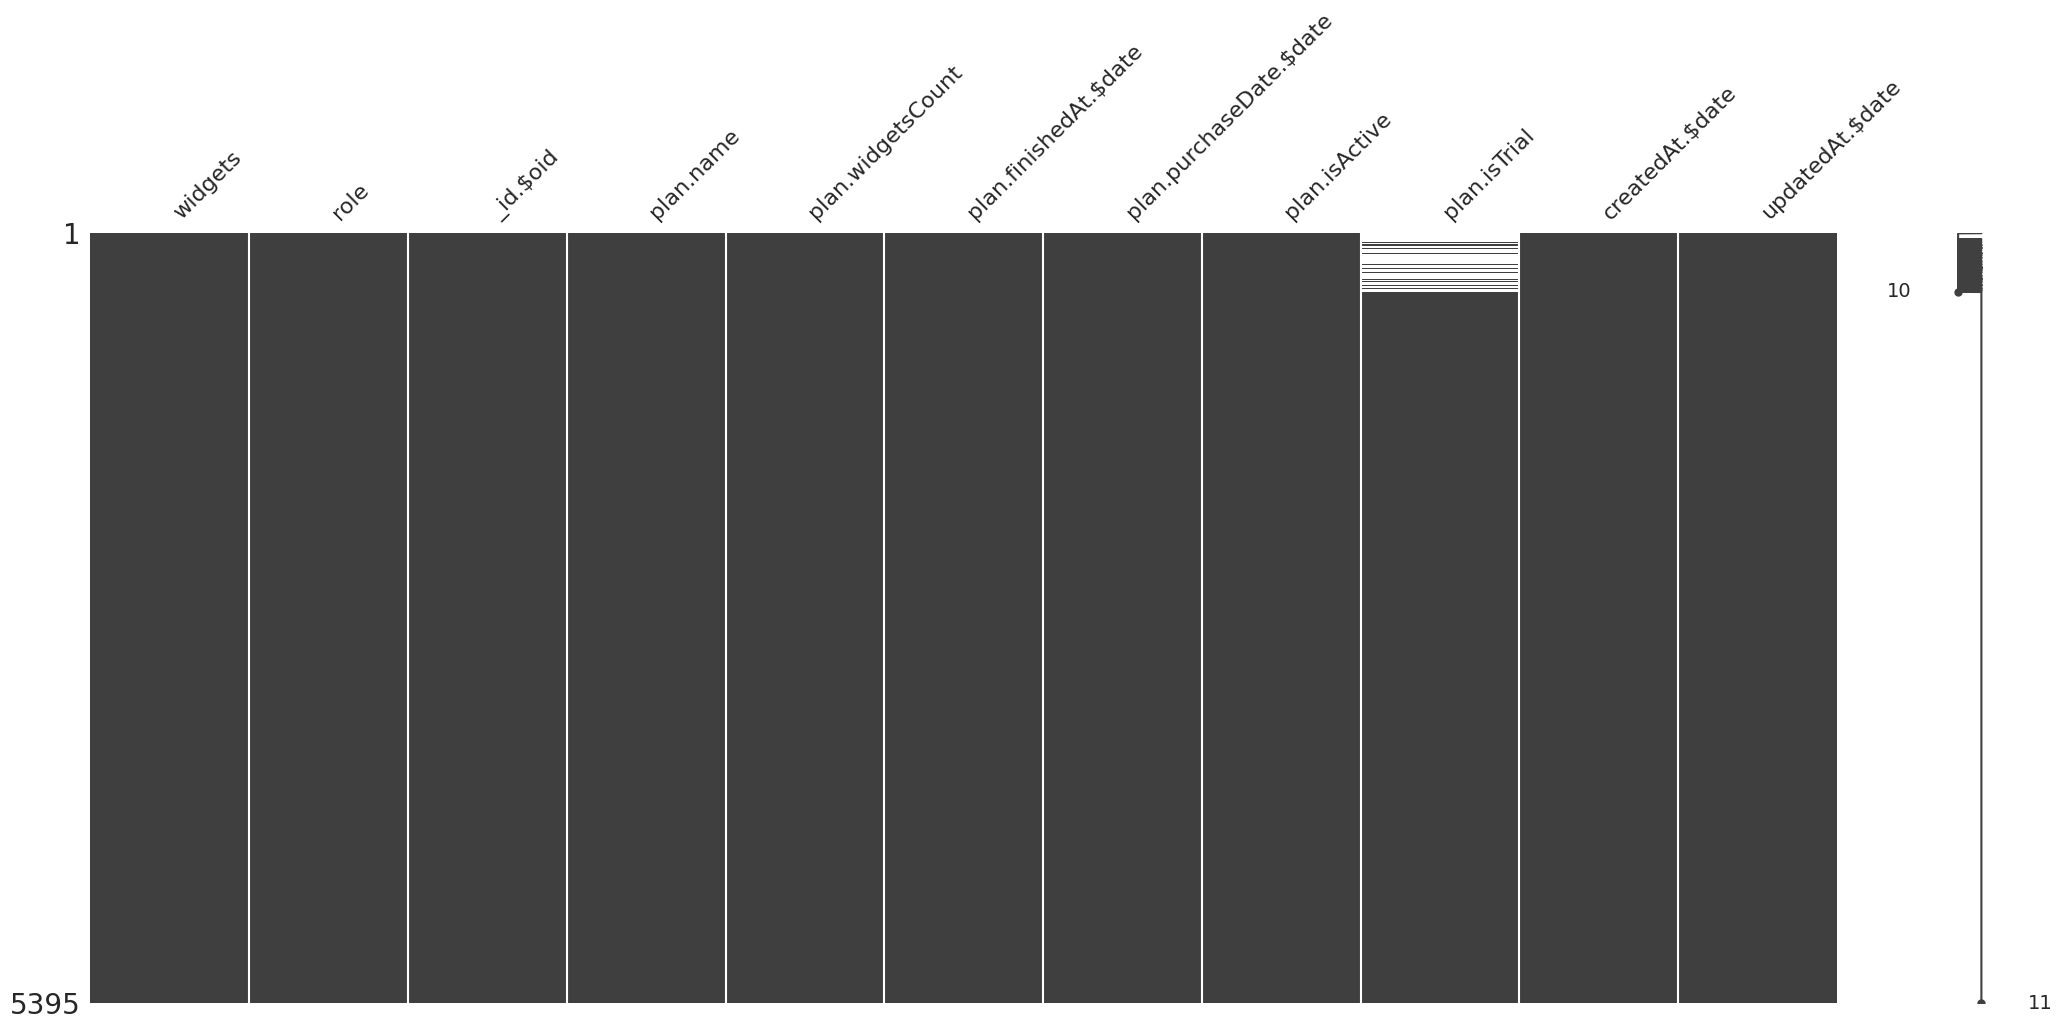

In [37]:
msno.matrix(df_users)

plt.show()

In [38]:
missing_us = (
    df_users.isnull().sum() / df_users.shape[0] * 100
    ).round(2).sort_values(
        ascending=False).copy().reset_index().rename(columns={
            'index': 'feature',
            0: 'missing'}
          ).query('missing > 0')

In [39]:
missing_us['missing'] = missing_us['missing'].apply(lambda x: str(x) + '%')
missing_us

feature missing
0  plan.isTrial   6.19%

В таблице обнаружены пропуски данных исключительно в поле `plan.isTrial`. Процент пропущенных значений составляет 6.19%, при этом они имеют специфическое расположение - сгруппированы в одном месте таблицы.

Важно отметить, что удаление этих пропусков невозможно, так как это приведет к потере значительного количества пользовательских данных. Заполнение пропусков также недопустимо, поскольку существует высокий риск существенного искажения исходной информации.

**Общий вывод:**

В ходе анализа пропусков были рассмотрены четыре таблицы: df_payments, df_plans, df_users и df_widgets.
Мы удалили пустые поля из таблиц df_payments и df_widgets, а также исключили из df_payments поля, содержащие дублирующую информацию, которая уже присутствовала в присоединённой таблице df_plans.
Из таблицы df_plans были удалены поля, не несущие полезной информации. Пропуски в данных были заполнены там, где это было возможно и уместно.
Те пропуски, заполнение которых могло бы привести к искажению данных или не имело практического смысла, оставлены без изменений. При этом соответствующие строки не были удалены, чтобы сохранить потенциально полезную информацию для последующего анализа.

### Преобразование данных

Переименуем поля в таблице df_payments_plans. Выполним следующие преобразования:

* приведём к нижнему регистру;
* удалим лишние приставки;
* преобразуем в формат snake_case для повышения читабельности.


In [40]:
df_payments_plans.sample(2)

orderId     status  \
3387  4096b302-789c-448d-84ba-1d1bdf7297df  SUCCEEDED   
1029  4a5cc0e4-4e87-41e6-9709-1eb79394b894  CANCELLED   

                    _id.$oid_x           updatedAt.$date  \
3387  67386f9feb335c96538bc657  2024-11-16T10:11:29.682Z   
1029  63d7aee456f49c3b63074c35  2023-01-30T12:52:58.873Z   

                     user.$oid           createdAt.$date  \
3387  6542260ab732725ed52b8744  2024-11-16T10:10:39.414Z   
1029  618920bef58834c268770a1f  2023-01-30T11:49:56.917Z   

                details.planId details.planName  details.amount  \
3387  60eac7c090455c3f927ec8d1   Medium - 1 год            5350   
1029  60eac72290455cce1f7ec8a4    Start - 1 год            2100   

      details.months            name  widgetsCount  value  months  custom  \
3387              12  Medium - 1 год             3   5350      12   False   
1029              12   Start - 1 год             1   2490      12   False   

                    _id.$oid_y  
3387  60eac7c090455c3f927ec8d1  
1029  60eac72290455cce1f7ec8a4

In [41]:
df_payments_plans = df_payments_plans.rename(columns={'orderId': 'order_id',
                                                      '_id.$oid_x' : 'payment_id',
                                                      'updatedAt.$date' : 'updated_at',
                                                      'user.$oid' : 'user_id',
                                                      'createdAt.$date' : 'created_at',
                                                      'details.planId' : 'details_plan_id',
                                                      'details.planName' : 'details_plan_name',
                                                      'details.amount' : 'details_amount',
                                                      'details.months' : 'details_months',
                                                      'widgetsCount' : 'widgets_count',
                                                      '_id.$oid_y' : 'plan_id'})

In [42]:
df_payments_plans.sample()

order_id     status  \
1340  64ac41f1-1e06-43f8-957c-9d1ff6658eac  SUCCEEDED   

                    payment_id                updated_at  \
1340  645cd688dd276bb9344f277f  2023-05-11T11:56:30.621Z   

                       user_id                created_at  \
1340  644c0d4b671d5b64780ded67  2023-05-11T11:50:32.205Z   

               details_plan_id details_plan_name  details_amount  \
1340  60eac72290455cce1f7ec8a4     Start - 1 год            2100   

      details_months           name  widgets_count  value  months  custom  \
1340              12  Start - 1 год              1   2490      12   False   

                       plan_id  
1340  60eac72290455cce1f7ec8a4

Преобразуем тип данных в полях `updated_at` и `created_at`	с object на datetime

In [43]:
df_payments_plans['updated_at'] = pd.to_datetime(df_payments_plans['updated_at'], utc=True).dt.tz_convert('Europe/Moscow')
df_payments_plans['created_at'] = pd.to_datetime(df_payments_plans['created_at'], utc=True).dt.tz_convert('Europe/Moscow')

In [44]:
df_payments_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797 entries, 0 to 3796
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype                        
---  ------             --------------  -----                        
 0   order_id           3797 non-null   object                       
 1   status             3797 non-null   object                       
 2   payment_id         3797 non-null   object                       
 3   updated_at         3386 non-null   datetime64[ns, Europe/Moscow]
 4   user_id            3797 non-null   object                       
 5   created_at         3797 non-null   datetime64[ns, Europe/Moscow]
 6   details_plan_id    3797 non-null   object                       
 7   details_plan_name  3797 non-null   object                       
 8   details_amount     3797 non-null   int64                        
 9   details_months     3797 non-null   int64                        
 10  name               3797 non-null   object       

Теперь проделаем всё тоже самое, но для таблицы df_widgets.

In [45]:
df_widgets.sample()

title                       url  hideWatermark  customSettings  \
1104  Отзыв  https://quietgardens.ru/          False               0   

      customStyles  hideEmptyReviews  ratingThreshold  totalRating  \
1104             0             False                0          0.0   

      totalReviewAmount sources                  _id.$oid  \
1104                  0      []  6632518dec28777929d250bf   

                     user.$oid           createdAt.$date  \
1104  66325164ec28775a7fd24ef2  2024-05-01T14:28:29.720Z   

               updatedAt.$date  reviewAmount.doubleGis  reviewAmount.yaMarket  \
1104  2024-05-01T14:28:29.721Z                       0                      0   

      reviewAmount.instagram  reviewAmount.vkontakte  reviewAmount.avito  \
1104                       0                       0                 0.0   

      reviewAmount.googleMap  reviewAmount.yaSprav  reviewStars.one  \
1104                     0.0                   0.0                0   

      reviewStars.two  reviewStars.three  reviewStars.four  reviewStars.five  
1104                0                  0                 0                 0

In [46]:
df_widgets = df_widgets.rename(columns={'hideWatermark' : 'hide_watermark',
                                        'customSettings' : 'is_custom_settings',
                                        'customStyles' : 'is_custom_styles',
                                        'hideEmptyReviews' : 'hide_empty_reviews',
                                        'ratingThreshold' : 'rating_threshold',
                                        'totalRating' : 'total_rating',
                                        'totalReviewAmount' : 'total_review_amount',
                                        '_id.$oid'  : 'widget_id',
                                        'user.$oid' : 'user_id',
                                        'createdAt.$date' : 'created_at',
                                        'updatedAt.$date' : 'updated_at',
                                        'reviewAmount.doubleGis' : 'review_amount_double_gis',
                                        'reviewAmount.yaMarket' : 'review_amount_ya_market',
                                        'reviewAmount.instagram' : 'review_amount_instagram',
                                        'reviewAmount.vkontakte' : 'review_amount_vkontakte',
                                        'reviewAmount.avito' : 'review_amount_avito',
                                        'reviewAmount.googleMap' : 'review_amount_google_map',
                                        'reviewAmount.yaSprav	' : 'review_amount_ya_sprav',
                                        'reviewStars.one' : 'review_stars_one',
                                        'reviewStars.two' : 'review_stars_two',
                                        'reviewStars.three' : 'review_stars_three',
                                        'reviewStars.four' : 'review_stars_four',
                                        'reviewStars.five' : 'review_stars_five',
                                        'reviewAmount.yaSprav' : 'review_amount_ya_sprav'})

In [47]:
df_widgets['updated_at'] = pd.to_datetime(df_widgets['updated_at'], utc=True).dt.tz_convert('Europe/Moscow')
df_widgets['created_at'] = pd.to_datetime(df_widgets['created_at'], utc=True).dt.tz_convert('Europe/Moscow')

In [48]:
df_widgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype                        
---  ------                    --------------  -----                        
 0   title                     2178 non-null   object                       
 1   url                       2178 non-null   object                       
 2   hide_watermark            2178 non-null   bool                         
 3   is_custom_settings        2178 non-null   int64                        
 4   is_custom_styles          2178 non-null   int64                        
 5   hide_empty_reviews        2178 non-null   bool                         
 6   rating_threshold          2178 non-null   int64                        
 7   total_rating              2178 non-null   float64                      
 8   total_review_amount       2178 non-null   int64                        
 9   sources                   2178 non-null  

Остался df_users.

In [49]:
df_users.sample()

widgets  role                  _id.$oid  \
4232  [{'$oid': '66b66ede4e55c883bbd97e93'}]  USER  66b66df84e55c81e94d97812   

       plan.name  plan.widgetsCount     plan.finishedAt.$date  \
4232  Бесплатный                  1  2024-08-23T19:28:56.488Z   

       plan.purchaseDate.$date  plan.isActive plan.isTrial  \
4232  2024-08-09T19:28:56.490Z          False         True   

               createdAt.$date           updatedAt.$date  
4232  2024-08-09T19:28:56.487Z  2024-08-24T00:00:00.044Z

In [50]:
df_users = df_users.rename(columns={'_id.$oid' : 'user_id',
                                    'plan.name' : 'plan_name',
                                    'plan.widgetsCount' : 'plan_widgets_count',
                                    'plan.finishedAt.$date' : 'plan_finished_at',
                                    'plan.purchaseDate.$date' : 'plan_purchase_date',
                                    'plan.isActive' : 'plan_is_active',
                                    'plan.isTrial' : 'plan_is_trial',
                                    'createdAt.$date' : 'created_at',
                                    'updatedAt.$date' : 'updated_at'})

В текущей структуре данных существует проблема с полем `widgets`: оно содержит множество пустых массивов, а также массивы с большим количеством виджетов. При попытке распаковки данных таким образом, чтобы каждому id виджета соответствовала отдельная строка, неизбежно возникнет значительное количество дубликатов.

Однако удаление данного поля обосновано по нескольким причинам:

* Отсутствует критическая необходимость в этой колонке, так как таблицы можно эффективно объединить по `user_id`
* Существует четкая связь “один ко многим” между пользователями и виджетами:
    * Один пользователь может иметь несколько виджетов
    * Каждый виджет принадлежит только одному пользователю

На основании вышеизложенного предлагается удалить поле `widgets` из таблицы.

In [51]:
df_users.drop(columns=['widgets'], inplace=True)

In [52]:
df_users['updated_at'] = pd.to_datetime(df_users['updated_at'], utc=True).dt.tz_convert('Europe/Moscow')
df_users['created_at'] = pd.to_datetime(df_users['created_at'], utc=True).dt.tz_convert('Europe/Moscow')
df_users['plan_finished_at'] = pd.to_datetime(df_users['plan_finished_at'], utc=True).dt.tz_convert('Europe/Moscow')
df_users['plan_purchase_date'] = pd.to_datetime(df_users['plan_purchase_date'], utc=True).dt.tz_convert('Europe/Moscow')

In [53]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5395 entries, 0 to 5394
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype                        
---  ------              --------------  -----                        
 0   role                5395 non-null   object                       
 1   user_id             5395 non-null   object                       
 2   plan_name           5395 non-null   object                       
 3   plan_widgets_count  5395 non-null   int64                        
 4   plan_finished_at    5395 non-null   datetime64[ns, Europe/Moscow]
 5   plan_purchase_date  5395 non-null   datetime64[ns, Europe/Moscow]
 6   plan_is_active      5395 non-null   bool                         
 7   plan_is_trial       5061 non-null   object                       
 8   created_at          5395 non-null   datetime64[ns, Europe/Moscow]
 9   updated_at          5395 non-null   datetime64[ns, Europe/Moscow]
dtypes: bool(1), datetime64[ns, Europe/Mo

В процессе обработки данных были выполнены следующие преобразования:

* Конвертация дат: значения типа object были преобразованы в формат datetime64 с привязкой к часовому поясу МСК. Это было сделано для удобства восприятия, так как исходные даты содержали информацию о часовом поясе.
* Реновация полей: все поля были переименованы с учетом единого стиля именования, что сделало их более понятными и читабельными для дальнейшей работы.

### Анализ дубликатов

In [54]:
df_payments_plans.duplicated().sum(), df_payments_plans['payment_id'].duplicated().sum(), df_payments_plans[['order_id', 'created_at']].duplicated().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [55]:
df_payments_plans['status'].unique()

array(['SUCCEEDED', 'CANCELLED', 'RETURNED'], dtype=object)

In [56]:
df_payments_plans['details_plan_name'].unique()

array(['Start - 1 год', 'Medium - 3 мес', 'Start - 3 мес',
       'Medium - 1 год', 'Expert - 3 мес', 'Expert - 1 год',
       '80 виджетов - 6 мес', 'Expert 15 - 1 год', '80 виджетов - 3 мес',
       'Start - 1 год - 2 виджета', 'Expert - 1 год (доплата)',
       'Extra - 1 год (доплата)', 'Start - 1 год - 2 виджета (доплата)',
       '150 виджетов - 3 мес', 'Expert 16 - 1 год', 'Extra - 1 год',
       'Medium - 1 год - 4 виджета', 'Medium - 1 год (доплата)',
       'Expert - 1 месяц (аванс)', 'Expert 12 - 1 год (доплата)',
       'Extra - 3 месяца'], dtype=object)

В таблице df_payments_plans нет дубликатов.

In [57]:
df_widgets['widget_id'].duplicated().sum(), df_widgets[['user_id', 'created_at']].duplicated().sum()

(np.int64(0), np.int64(0))

В таблице df_widgets нет дубликатов.

In [58]:
df_users.duplicated().sum(), df_users[['plan_name', 'created_at']].duplicated().sum()

(np.int64(0), np.int64(0))

In [59]:
df_users['plan_name'].unique()

array(['Extra - 1 год', 'Expert - 1 год', 'Start - 3 мес', 'Бесплатный',
       'Технический', 'Start - 1 год', 'Medium - 3 мес', 'Medium - 1 год',
       'Expert - 3 мес', '150 виджетов - 3 мес', 'Expert 16 - 1 год',
       'Medium - 1 год - 4 виджета', 'Start - 1 год - 2 виджета',
       'Extra - 3 месяца', 'Expert 12 - 1 год'], dtype=object)

In [60]:
df_users['role'].unique()

array(['ADMIN', 'USER'], dtype=object)

В таблице df_users дубликатов нет.

**Вывод:**

В таблицах дубликатов нет.

### Анализ аномальных значений

In [61]:
def anomaly_detection(data):
    for column in data.columns:
        if data[column].dtype == bool:
            continue
        if not pd.api.types.is_numeric_dtype(data[column]):
            continue

        x_values = pd.Series(range(len(data[column])))

        fig, ax = plt.subplots(figsize=(6, 4))

        sns.scatterplot(
            data=data,
            x=x_values,
            y=column,
            alpha=0.7,
            ax=ax
        )

        ax.set_title(f'Аномалии в колонке: {column}', fontsize=14)
        ax.set_xlabel('Индекс наблюдения', fontsize=12)
        ax.set_ylabel('Значение', fontsize=12)

        median_val = data[column].median()
        p2_5, p97_5 = np.nanpercentile(data[column], [2.5, 97.5])

        ax.axhline(p97_5, color='blue', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
        ax.axhline(median_val, color='green', linestyle='-', label=f'Медиана: {median_val:.2f}')
        ax.axhline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')

        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)

        plt.tight_layout()
        plt.show()
        print()

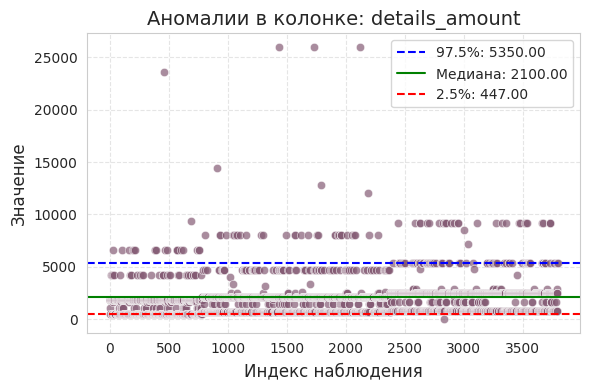

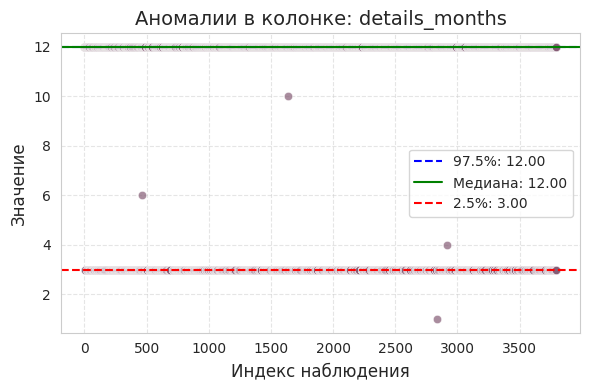

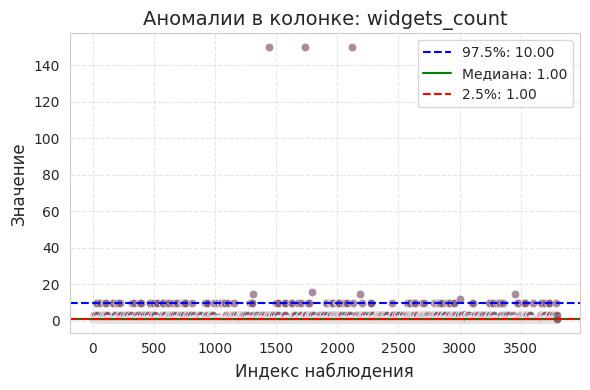

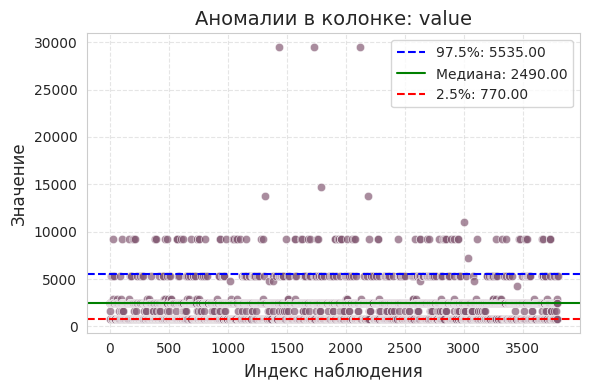

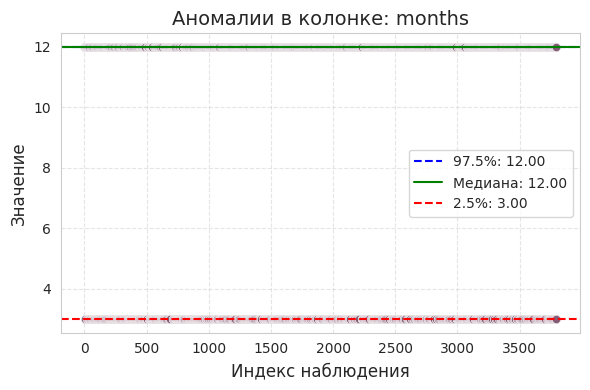

In [62]:
anomaly_detection(df_payments_plans)

В поле `details_amount` распределение значений характеризуется следующими статистическими показателями:

* 2.5-й перцентиль: 447
* 97.5-й перцентиль: 5350
* Медиана: 2100

95% всех наблюдений попадают в диапазон от 447 до 5350. При этом обнаружено 7 сильно выделяющихся значений, превышающих 10 000. Рассмотрим эти аномальные значения более детально.

In [63]:
df_payments_plans.query("details_amount > 10000")

order_id     status  \
464   a73ff8fe-0243-47ce-8827-621cd261dd2f  SUCCEEDED   
914   4c8fc649-0425-4878-81de-89c52e83d78b  SUCCEEDED   
1439  d9f8c3df-dd48-45e0-8704-e84f421ce8a9  SUCCEEDED   
1736  c9246a87-e9c1-4f28-9bd4-6970c3b71075  SUCCEEDED   
1790  e9bb3a60-5b74-4cf3-b921-541f4671a524  SUCCEEDED   
2122  dcd4fbf6-16c4-4571-b710-da4d2f01ea52  SUCCEEDED   
2188  6feb0357-92ee-451c-8f2b-da15bab46da7  SUCCEEDED   

                    payment_id updated_at                   user_id  \
464   62a0437c903e11424f3c2407        NaT  629771d26daca03f77859e34   
914   6392a0ee2ba494aeed57991a        NaT  629771d26daca03f77859e34   
1439  6483bdba69843035e7b21b17        NaT  629771d26daca03f77859e34   
1736  65083358b9a6c9f9aa2439ca        NaT  629771d26daca03f77859e34   
1790  651ee3775d9bb7e460aa119e        NaT  62a22eb3381b1e4456ddbe85   
2122  65a79eec23455658680e5721        NaT  629771d26daca03f77859e34   
2188  65c08d550fa242234ce33f40        NaT  63a9475e2ba494a0660bb8d5   

                           created_at           details_plan_id  \
464  2022-06-08 09:36:44.809000+03:00  60eac84590455c57287ec8f5   
914  2022-12-08 05:43:58.412000+03:00  60eac84590455c57287ec8f5   
1439 2023-06-10 03:03:06.794000+03:00  64790b4e04ea17d8def4f19d   
1736 2023-09-18 14:24:08.447000+03:00  64790b4e04ea17d8def4f19d   
1790 2023-10-05 19:25:27.125000+03:00  651ee3695d9bb7f812aa115d   
2122 2024-01-17 12:33:32.664000+03:00  64790b4e04ea17d8def4f19d   
2188 2024-02-05 10:25:09.933000+03:00  64512a7841905e8972c8cf4d   

         details_plan_name  details_amount  details_months  \
464    80 виджетов - 6 мес           23600               6   
914    80 виджетов - 3 мес           14400               3   
1439  150 виджетов - 3 мес           26000               3   
1736  150 виджетов - 3 мес           26000               3   
1790     Expert 16 - 1 год           12800              12   
2122  150 виджетов - 3 мес           26000               3   
2188         Extra - 1 год           12000              12   

                      name  widgets_count  value  months  custom  \
464         Expert - 3 мес             10   2850       3   False   
914         Expert - 3 мес             10   2850       3   False   
1439  150 виджетов - 3 мес            150  29500       3    True   
1736  150 виджетов - 3 мес            150  29500       3    True   
1790     Expert 16 - 1 год             16  14720      12    True   
2122  150 виджетов - 3 мес            150  29500       3    True   
2188         Extra - 1 год             15  13800      12    True   

                       plan_id  
464   60eac84590455c57287ec8f5  
914   60eac84590455c57287ec8f5  
1439  64790b4e04ea17d8def4f19d  
1736  64790b4e04ea17d8def4f19d  
1790  651ee3695d9bb7f812aa115d  
2122  64790b4e04ea17d8def4f19d  
2188  64512a7841905e8972c8cf4d

В основном это клиенты, выбравшие тарифы повышенной стоимости.

В поле `details_months` большинство значений соответствует стандартным тарифным планам (3 и 12 месяцев), однако обнаружены 4 аномальных значения. Посмотрим на них в таблице.

In [64]:
df_payments_plans.query("details_months < 12 and details_months != 3")

order_id     status  \
464   a73ff8fe-0243-47ce-8827-621cd261dd2f  SUCCEEDED   
1633  0d1170cb-b94c-4291-9bf2-8710db539ae0  SUCCEEDED   
2833  f75fb3cc-fe90-470b-966c-596700b2986f  SUCCEEDED   
2918  c5e9dbf7-6db1-4fa4-a4ed-5070c2250e13  SUCCEEDED   

                    payment_id                       updated_at  \
464   62a0437c903e11424f3c2407                              NaT   
1633  64db34266e0fc241b4385aa9                              NaT   
2833  66aa4aca82915e5393ec9b45                              NaT   
2918  66c74e3904b2418d2fb2968a 2024-08-22 15:50:04.233000+03:00   

                       user_id                       created_at  \
464   629771d26daca03f77859e34 2022-06-08 09:36:44.809000+03:00   
1633  62a9bbda381b1ebfc757cf5b 2023-08-15 11:15:34.957000+03:00   
2833  60d19f322d4a5122cd19b066 2024-07-31 17:31:38.472000+03:00   
2918  658aab0dc51e3d7f6331f7fd 2024-08-22 16:48:44.964000+03:00   

               details_plan_id         details_plan_name  details_amount  \
464   60eac84590455c57287ec8f5       80 виджетов - 6 мес           23600   
1633  60eac82590455caaa17ec8e9  Expert - 1 год (доплата)            2574   
2833  60eac82590455caaa17ec8e9  Expert - 1 месяц (аванс)               0   
2918  60eac7c090455c3f927ec8d1  Medium - 1 год (доплата)            1783   

      details_months            name  widgets_count  value  months  custom  \
464                6  Expert - 3 мес             10   2850       3   False   
1633              10  Expert - 1 год             10   9200      12   False   
2833               1  Expert - 1 год             10   9200      12   False   
2918               4  Medium - 1 год              3   5350      12   False   

                       plan_id  
464   60eac84590455c57287ec8f5  
1633  60eac82590455caaa17ec8e9  
2833  60eac82590455caaa17ec8e9  
2918  60eac7c090455c3f927ec8d1

Все выявленные аномалии имеют логическое объяснение, за исключением записи с идентификатором платежа 66aa4aca82915e5393ec9b45. В данной записи наблюдается противоречие: поле `details_amount` равно 0, при этом в `details_months`  1 месяц. В скобках указано, что это аванс, но поскольку не понятно был ли в действительности платёж, то лучше удалить эту строку

In [65]:
df_payments_plans = df_payments_plans.query('payment_id	!= "66aa4aca82915e5393ec9b45"')

Проверим есть ли ещё нулевые значения в поле `details_amount`

In [66]:
df_payments_plans.query('details_amount == 0')

Empty DataFrame
Columns: [order_id, status, payment_id, updated_at, user_id, created_at, details_plan_id, details_plan_name, details_amount, details_months, name, widgets_count, value, months, custom, plan_id]
Index: []

В поле `widgets_count` наблюдается следующая статистика:

* 95% значений находятся в диапазоне от 1 до 10 виджетов
* Медиана составляет 1 виджет
* Присутствуют три аномальных значения, достигающие 150 виджетов

Таким образом, большинство пользователей имеют небольшое количество виджетов, при этом есть несколько исключений с существенно большим числом.Поскольку мы уже знаем, что есть тариф с 150 виджетами, то нет смысла более детально исследовать этот случай.

Дальше посмотрим на таблицу df_users

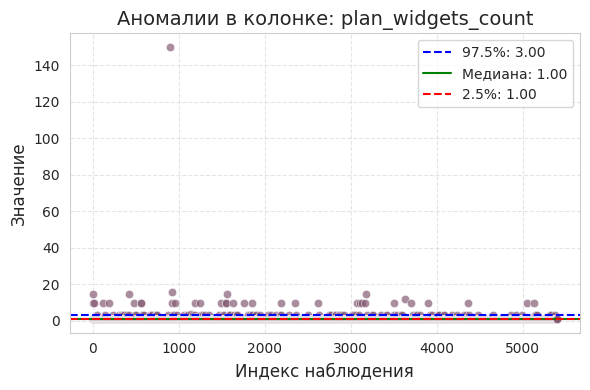

In [67]:
anomaly_detection(df_users)

Мы уже знаем, что одному из пользователей доступно 150 виджетов

In [68]:
df_widgets['review_amount_ya_market'].unique(), df_widgets['review_amount_instagram'].unique()

(array([0]), array([0]))

In [69]:
df_widgets = df_widgets.drop(columns=['review_amount_ya_market', 'review_amount_instagram'])

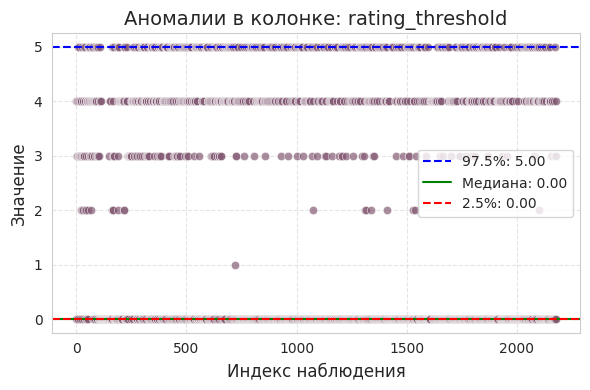

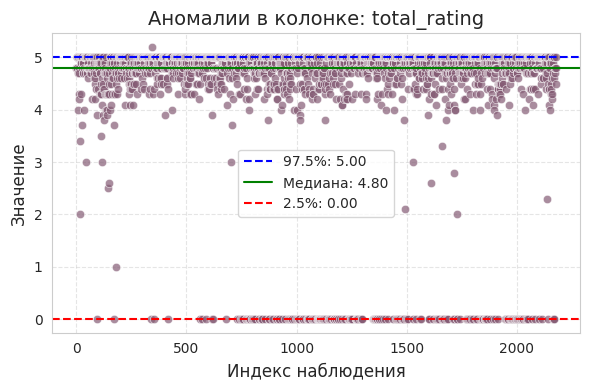

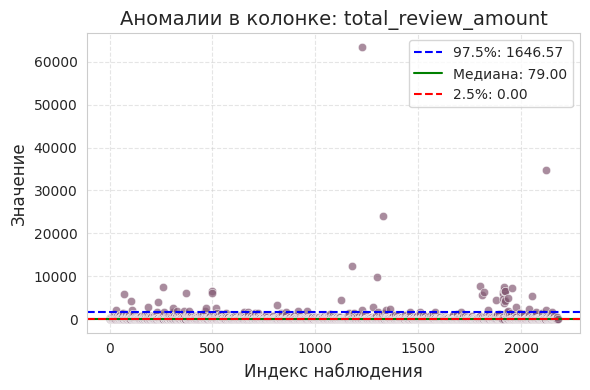

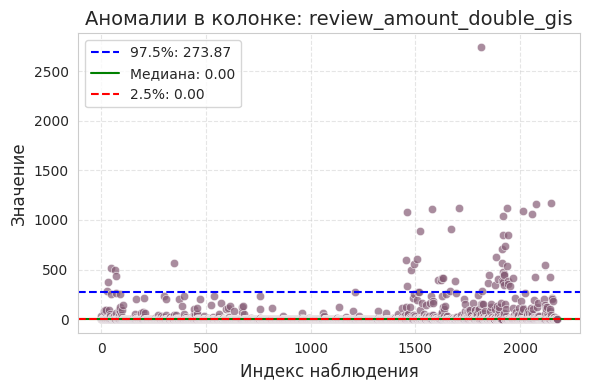

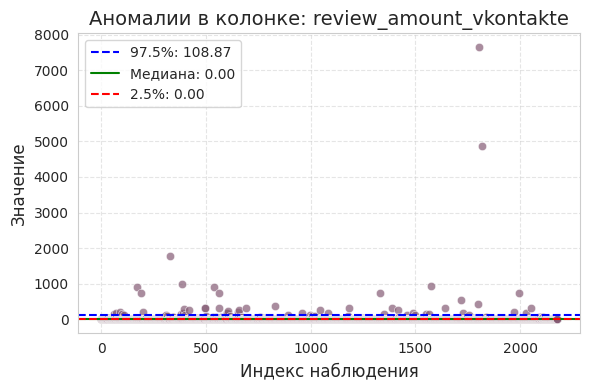

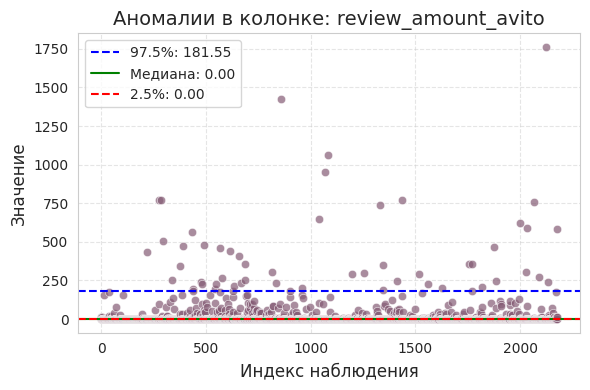

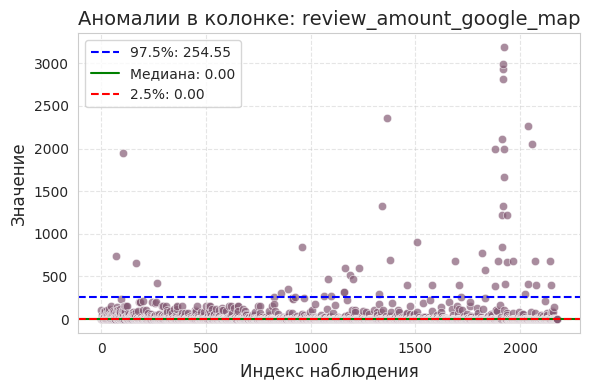

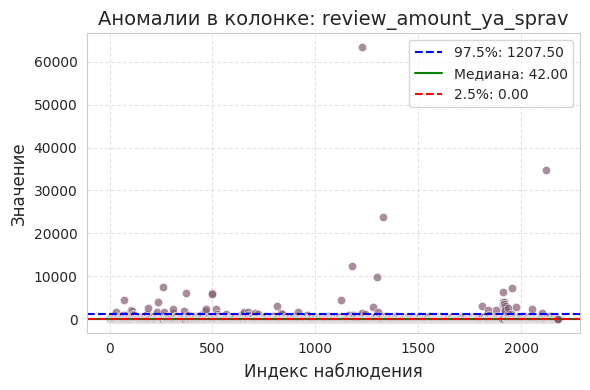

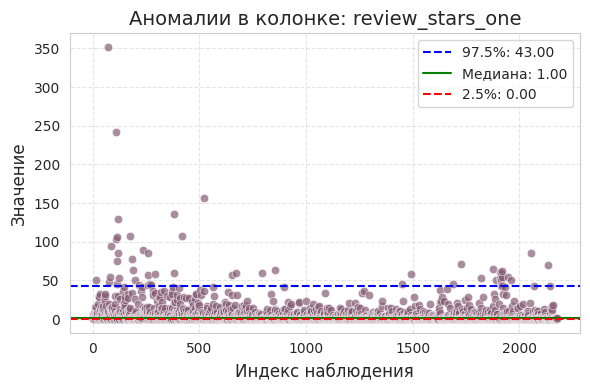

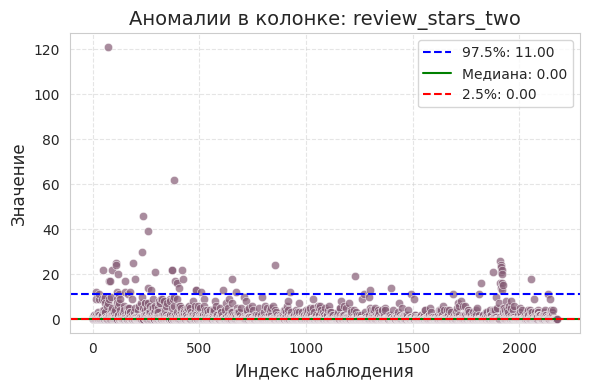

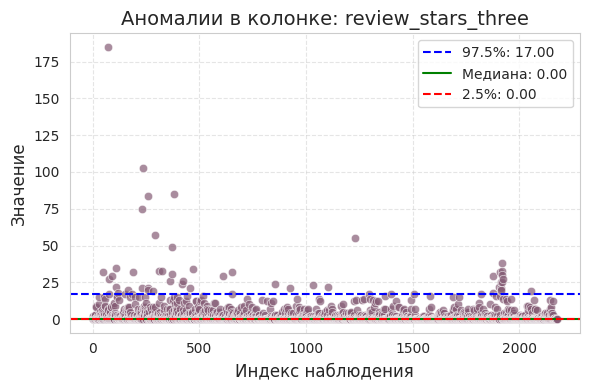

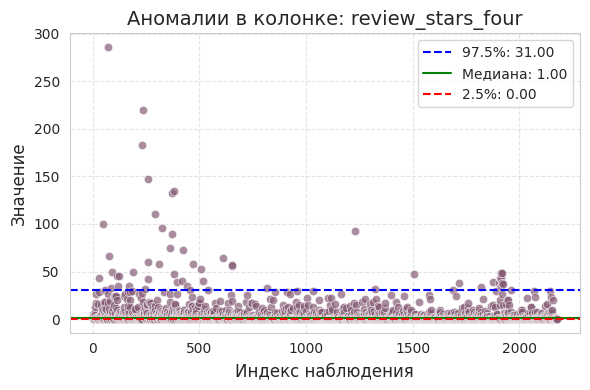

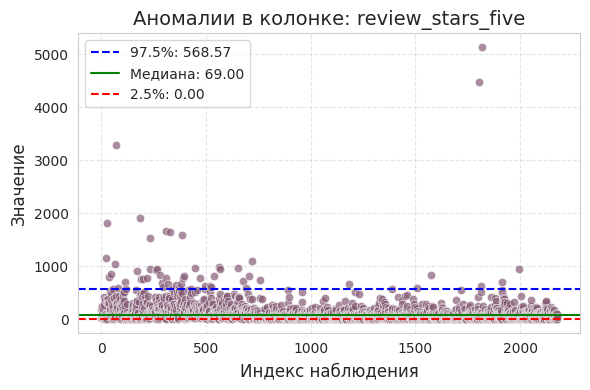

In [70]:
anomaly_detection(df_widgets.loc[:, 'hide_empty_reviews':])

`rating_threshold` задает минимальный рейтинг отзывов, необходимый для их отображения.
Среди возможных значений выделяется вариант "Скрывать отзывы с рейтингом ниже 1", который встречается только один раз.

In [71]:
df_widgets.query('rating_threshold == 1')

title                       url  hide_watermark  \
720  Страница отзывов  https://apelsingroup.ru/            True   

     is_custom_settings  is_custom_styles  hide_empty_reviews  \
720                   1                 0                True   

     rating_threshold  total_rating  total_review_amount  \
720                 1           4.8                  372   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                sources  \
720  [{'url': 'https://yandex.ru/maps/org/apelsin_grupp/1501350049/?ll=30.211304%2C59.985455&z=11', 'type': 'yaSprav', 'updatedAt': {'$date': '2025-02-02T14:01:39.391Z'}, 'lastAttemptedAt': {'$date': '2025-02-02T14:01:39.391Z'}}, {'url': 'https://yandex.ru/maps/org/apelsin_grupp/1172088171/?ll=30.337096%2C59.874187&z=16.61', 'type': 'yaSprav', 'updatedAt': {'$date': '2025-02-02T14:01:39.391Z'}, 'lastAttemptedAt': {'$date': '2025-02-02T14:01:39.391Z'}}, {'url': 'https://yandex.ru/maps/org/apelsin_grupp/47302999619/?ll=30.316452%2C60.049626&z=16.61', 'type': 'yaSprav', 'updatedAt': {'$date': '2025-02-02T14:01:39.391Z'}, 'lastAttemptedAt': {'$date': '2025-02-02T14:01:39.391Z'}}, {'type': 'avito', 'url': 'https://www.avito.ru/user/a711c5d8aff66c3b3697582a86ee743d/profile/all?src=search_seller_info&sellerId=a711c5d8aff66c3b3697582a86ee743d', 'updatedAt': {'$date': '2024-02-15T22:25:41.566Z'}, 'lastAttemptedAt': {'$date': '2025-02-04T00:36:05.740Z'}}, {'type': 'googleMap', 'url': 'https://www.google.by/maps/place/%D0%90%D0%BF%D0%B5%D0%BB%D1%8C%D1%81%D0%B8%D0%BD+%D0%B3%D1%80%D1%83%D0%BF%D0%BF/@59.985449,30.1903917,12z/data=!4m10!1m2!2m1!1z0LDQv9C10LvRjNGB0LjQvSDQs9GA0YPQv9C_!3m6!1s0x469633eed9af2145:0x9a01d0ef03d9dd2!8m2!3d59.985449!4d30.342827!15sChvQsNC_0LXQu9GM0YHQuNC9INCz0YDRg9C_0L8iA4gBAVodIhvQsNC_0LXQu9GM0YHQuNC9INCz0YDRg9C_0L-SARRyb29maW5nX3N1cHBseV9zdG9yZeABAA!16s%2Fg%2F11cs1sk34z?entry=ttu', 'updatedAt': {'$date': '2024-01-21T16:14:42.595Z'}, 'lastAttemptedAt': {'$date': '2024-01-21T16:14:42.595Z'}}]   

                    widget_id                   user_id  \
720  65ad42f2014ee360db6ceeda  65ad41e3014ee33c436ce673   

                          created_at                       updated_at  \
720 2024-01-21 19:14:42.606000+03:00 2025-02-04 03:36:05.740000+03:00   

     review_amount_double_gis  review_amount_vkontakte  review_amount_avito  \
720                         0                        0                 38.0   

     review_amount_google_map  review_amount_ya_sprav  review_stars_one  \
720                      31.0                   303.0             

Оставим эту строку как есть. Это странно, но вполне возможно.

Посмотрим теперь на поле `total_rating` — у него медиана 4.8. Также на графике видно, что основная часть точек группируется у верхней границы. Однако есть редкие значения в диапазоне от 1 до 3. Взглянем на них более подробно.

In [72]:
df_widgets.query('1 < total_rating < 3')

title                             url  hide_watermark  \
19    rasprodaza-divanov.ru  https://rasprodaza-divanov.ru/           False   
143      Qmarketing Academy          http://kurs-market.com           False   
150                Talentsy          http://kurs-market.com           False   
1491                 Отзывы         https://aviator-box.ru/           False   
1608     msk.goldenplata.ru     https://msk.goldenplata.ru/            True   
1714                kazprom                     kazprom.com           False   
1727                  Орион       https://opti-net.ru/Orion           False   
2135                   test         https://everylounge.ru/           False   

      is_custom_settings  is_custom_styles  hide_empty_reviews  \
19                     1                 0               False   
143                    1                 1               False   
150                    1                 1               False   
1491                   1                 0                True   
1608                   1                 0               False   
1714                   1                 0               False   
1727                   1                 0               False   
2135                   0                 0               False   

      rating_threshold  total_rating  total_review_amount  \
19                   3           2.0                    7   
143                  0           2.5                    8   
150                  0           2.6                    5   
1491                 0           2.1                  252   
1608                 4           2.6                    7   
1714                 0           2.8                   11   
1727                 0           2.0                  203   
2135                 0           2.3                  208   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sources  \
19                                                                                                                                                                                                                                                                                                  [{'url': 'https://yandex.ru/profile/113255713994', 'type': 'yaSprav', 'updatedAt': {'$date': '2025-02-10T21:01:37.011Z'}, 'lastAttemptedAt': {'$date': '2025-02-10T21:01:37.011Z'}}, {'type': 'googleMap', 'url': 'https://www.google.ru/maps/place/Rasprodazha+Divanov/@55.6116064,37.6061031,17z/data=!4m5!3m4!1s0x414ab261c98d5e4b:0x1832b5beba26826d!8m2!3d55.6116064!4d37.6082918', 'updatedAt': {'$date': '2022-11-30T05:20:00.332Z'}, 'lastAttemptedAt': {'$date': '2022-11-30T05:20:00.332Z'}}]   
143                                                                                                                        [{'url': 'https://yandex.ru/maps/org/qmarketing_academy/55844523778/?ll=37.581706%2C55.705725&mode=search&sll=37.538306%2C55.671254&sspn=0.084361%2C0.031768&text=Qmarketing%20Academy&z=11.96', 'type': 'yaSprav', 'updatedAt': {'$date': '2024-04-15T00:00:16.229Z'}, 'lastAttemptedAt': {'$date': '2024-04-15T00:00:16.229Z'}}, {'type': 'googleMap', 'url': 'https://www.google.com/maps/place/Qmarketing+Academy/@55.714217,37.6024369,14z/data=!4m8!1m2!2m1!1sQmarketing+Academy!3m4!1

Вполне возможно, что у этих компаний просто много негативных отзывов.

В целом, нет необходимости детально анализировать каждый выброс в этом датафрейме, поскольку это типичная ситуация, когда отдельные компании на различных платформах демонстрируют либо крайне низкие, либо, напротив, очень высокие оценки. Кроме того, количество отзывов о таких компаниях может существенно варьироваться: у одних их практически нет, у других – значительное превышение среднего показателя

**Общий вывод:**

В ходе анализа аномальных значений мы построили scatter plot для всех числовых полей, чтобы оценить характер их распределения. Для более детальной проверки использовались перцентили 2.5 и 97.5, а также медиана. Значения, которые значительно отклонялись от общей массы данных, дополнительно анализировались вручную с помощью срезов в таблице. Решения о дальнейшем включении или исключении таких данных принимались исходя из оценки их реалистичности и вероятных причин возникновения ошибок.

### Общий вывод по предобработке данных:

В рамках этапа предобработки данных были проведены работы по очистке, трансформации и первичному анализу данных для обеспечения их качества и пригодности к последующему анализу. Работа включала несколько ключевых направлений:

* Анализ и обработка пропусков: Были рассмотрены таблицы df_payments, df_plans, df_users и df_widgets. Пустые и дублирующие поля были удалены, нерелевантные признаки — исключены. Пропуски в данных были аккуратно заполнены там, где это не искажало бы информацию, в остальных случаях пропуски оставлены без изменений, чтобы сохранить потенциально важные данные.

* Преобразование данных: Выполнена конвертация значений типа object в формат datetime64 с учетом часового пояса МСК для повышения удобства работы с временными данными. Поля были переименованы в соответствии с единым стилем, что повысило читаемость и упростило дальнейшую обработку.

* Проверка на дубликаты: Во всех таблицах была проведена проверка на наличие дублирующихся строк. Дубликаты не были обнаружены.

* Анализ аномальных значений: Для всех числовых полей были построены scatter plot'ы для оценки распределения данных. Были использованы перцентили 2.5 и 97.5, а также медиана для выявления выбросов. Подозрительные значения анализировались вручную, срезами в таблицах, с последующей оценкой их реалистичности и потенциальных причин возникновения ошибок.

Все эти шаги позволили привести исходные данные к единому, чистому и интерпретируемому виду, что обеспечивает качественную основу для дальнейшего анализа.

## Исследовательский анализ

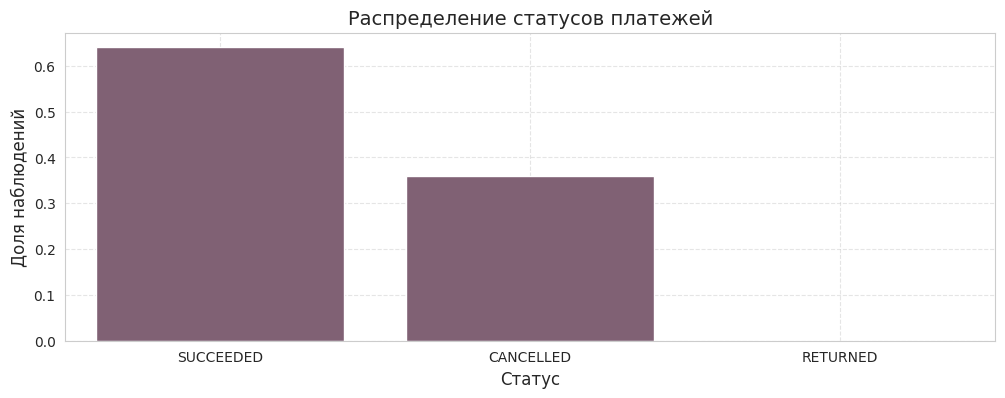

In [73]:
pp_bar = df_payments_plans['status'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='status',
            y='proportion',
            data=pp_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение статусов платежей', fontsize=14)
plt.xlabel('Статус', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()


В системе существует три возможных статуса платежей:

* succeeded (успешные платежи) - 64% от общего числа;
* cancelled (отмененные платежи) - примерно 36% от общего числа;
* returned (возвращенные платежи) - практически отсутствуют.

Таким образом, большинство транзакций успешно завершены, при этом заметная часть операций была отменена, а возвраты практически не встречаются.

In [74]:
df_pp_success = df_payments_plans.query('status == "SUCCEEDED"').copy().reset_index(drop=True)

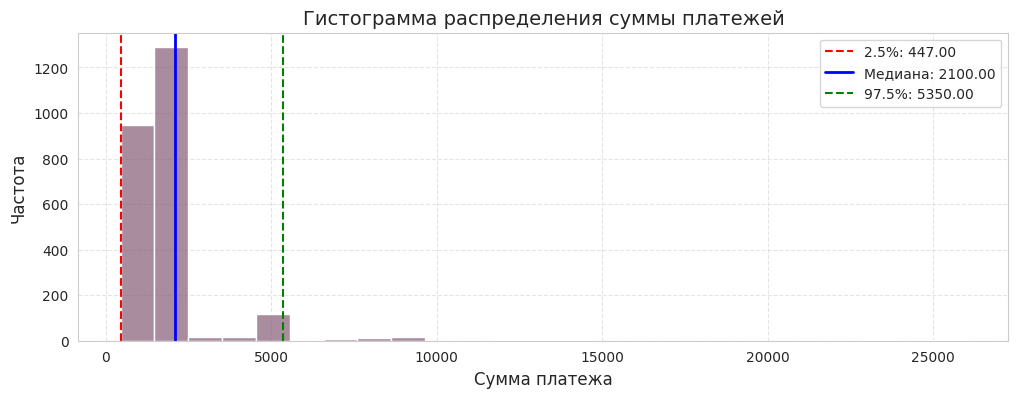

In [75]:
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=df_pp_success['details_amount'],#df_payments_plans['details_amount'],
    bins=25,
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(df_pp_success['details_amount'], [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Гистограмма распределения суммы платежей', fontsize=14)
ax1.set_xlabel('Сумма платежа', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
plt.show()

In [76]:
df_payments_plans['details_amount'].max()

26000

* Основной диапазон платежей составляет от 450 до 2500 рублей, где сосредоточена большая часть всех значений.
* Медианное значение равно 2100 рублей, что указывает на асимметричность распределения (медиана выше середины диапазона).
* Длинный правый хвост распределения достигает значения 26000 рублей, что свидетельствует о наличии значительных отклонений от основного диапазона.
* 95% всех значений находятся в диапазоне от 450 до 5350 рублей, что говорит о том, что только 2.5% платежей превышают 5350 рублей.

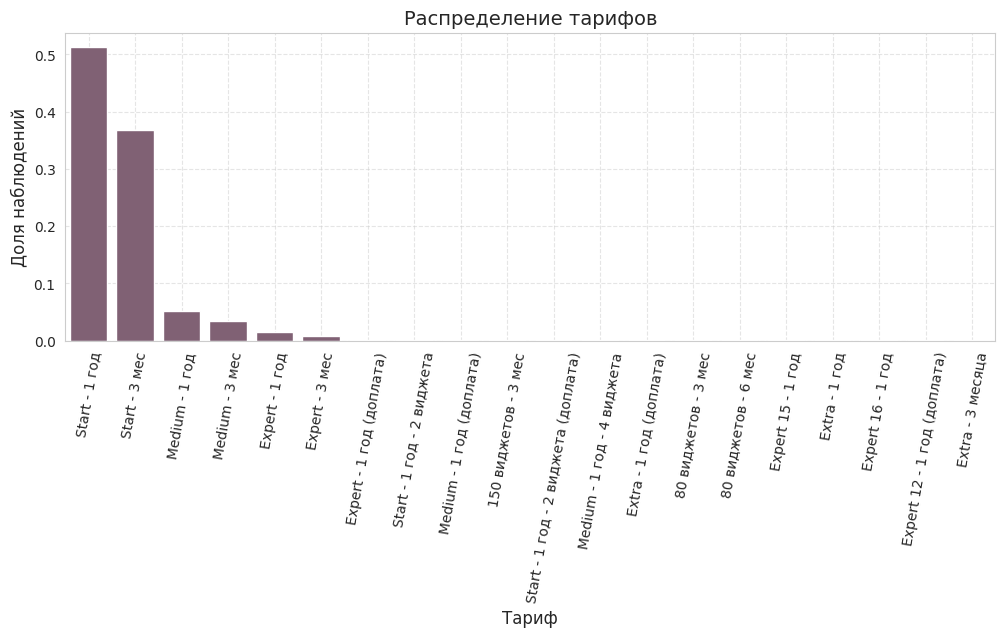

In [77]:
pp_bar = df_pp_success['details_plan_name'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='details_plan_name',
            y='proportion',
            data=pp_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение тарифов', fontsize=14)
plt.xlabel('Тариф', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.xticks(rotation=80)
plt.show()

Распределение продаж по тарифам:

* Start 1 год - примерно 51%
* Start 3 месяца - примерно 37%
* Medium 1 год - примерно 5%
* Medium 3 месяца - примерно 3.5%
* Expert 1 год - примерно 1.5%
* Expert 3 месяца - примерно 0.7%
* Прочие тарифы - примерно 0.1% или менее 0.1%

Всего распределение охватывает 100% продаж. Основной объем приходится на годовой и квартальный тарифы начального уровня (86.1% от общего числа продаж).

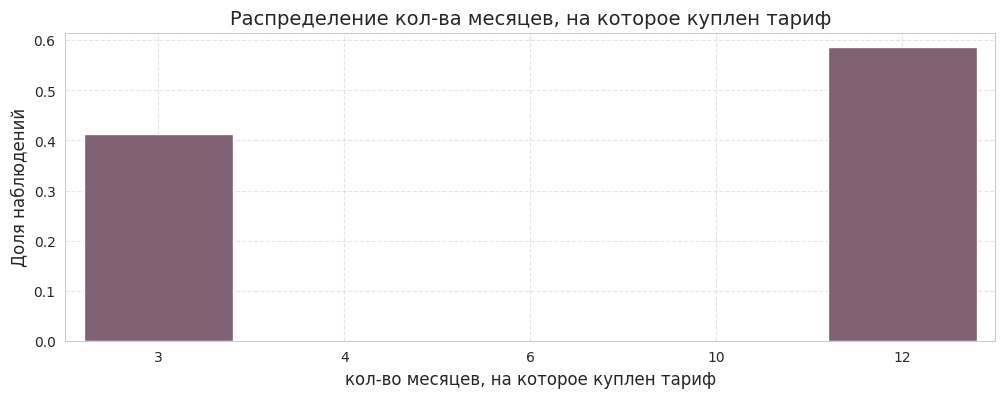

In [78]:
pp_bar = df_pp_success['details_months'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='details_months',
            y='proportion',
            data=pp_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение кол-ва месяцев, на которое куплен тариф', fontsize=14)
plt.xlabel('кол-во месяцев, на которое куплен тариф', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

Распределение покупок по типам тарифов выглядит следующим образом: 42% успешных покупок приходится на трёхмесячные тарифы, в то время как 58% на годовые тарифы.

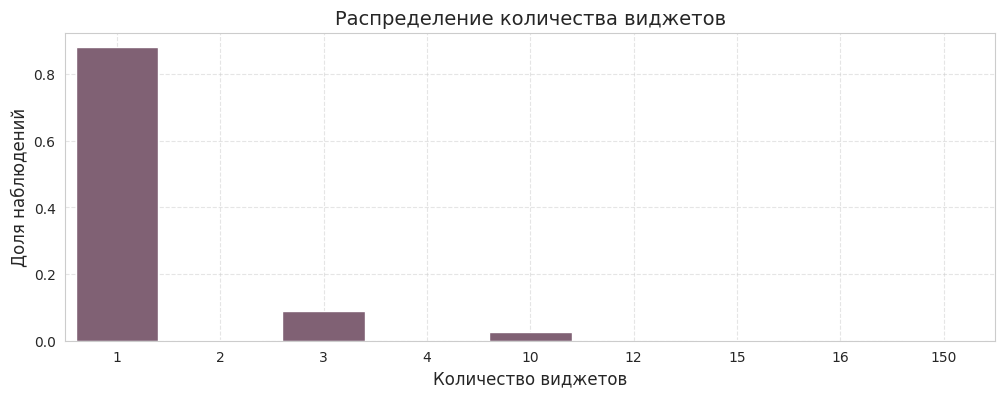

In [79]:
pp_bar = df_pp_success['widgets_count'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='widgets_count',
            y='proportion',
            data=pp_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение количества виджетов', fontsize=14)
plt.xlabel('Количество виджетов', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

Распределение количества виджетов по купленным тарифам:

* 86% тарифов предоставляют доступ к 1 виджету
* 10% тарифов предоставляют доступ к 3 виджетам
* 3% тарифов предоставляют доступ к 10 виджетам

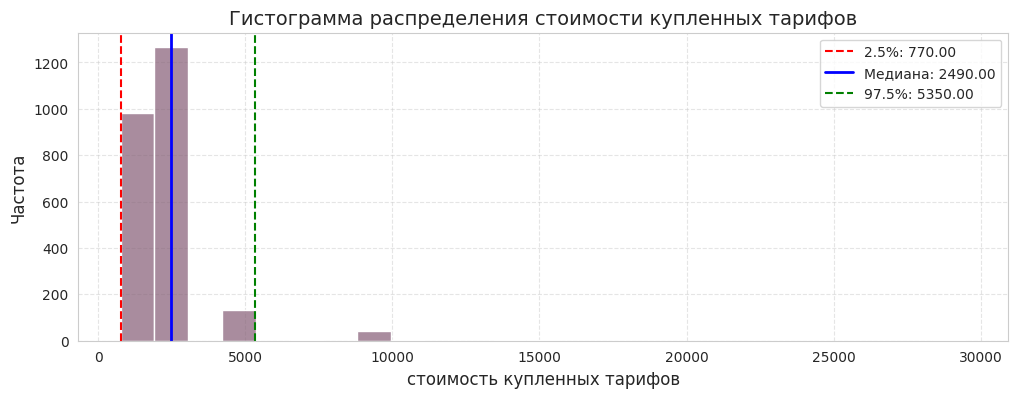

In [80]:
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=df_pp_success['value'],
    bins=25,
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(df_pp_success['value'], [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Гистограмма распределения стоимости купленных тарифов', fontsize=14)
ax1.set_xlabel('стоимость купленных тарифов', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
plt.show()

Характеристики стоимости тарифов:

* Основной диапазон: от 770 до 5350
* Медиана: 2490
* 95% значений находятся в диапазоне от 770 до 5350

Особенности распределения:

* Присутствует длинный хвост
* По форме распределение схоже с `details_amount`
* Средние значения немного выше, чем в details_amount

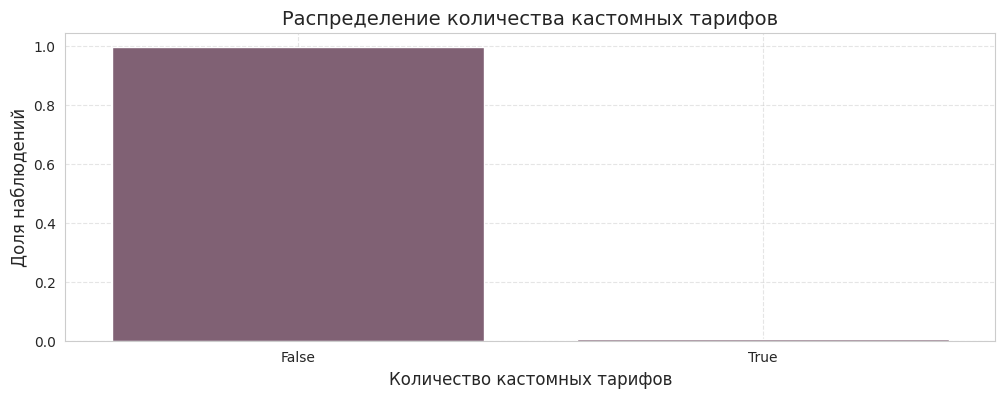

In [81]:
pp_bar = df_pp_success['custom'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='custom',
            y='proportion',
            data=pp_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение количества кастомных тарифов', fontsize=14)
plt.xlabel('Количество кастомных тарифов', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

Практически все тарифы не являются кастомными.

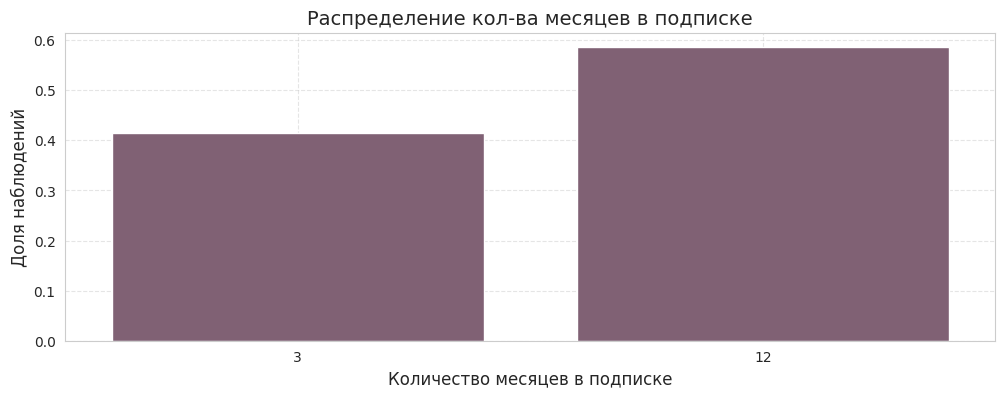

In [82]:
pp_bar = df_pp_success['months'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='months',
            y='proportion',
            data=pp_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение кол-ва месяцев в подписке', fontsize=14)
plt.xlabel('Количество месяцев в подписке', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

Такое же распределение, как в `details_months`

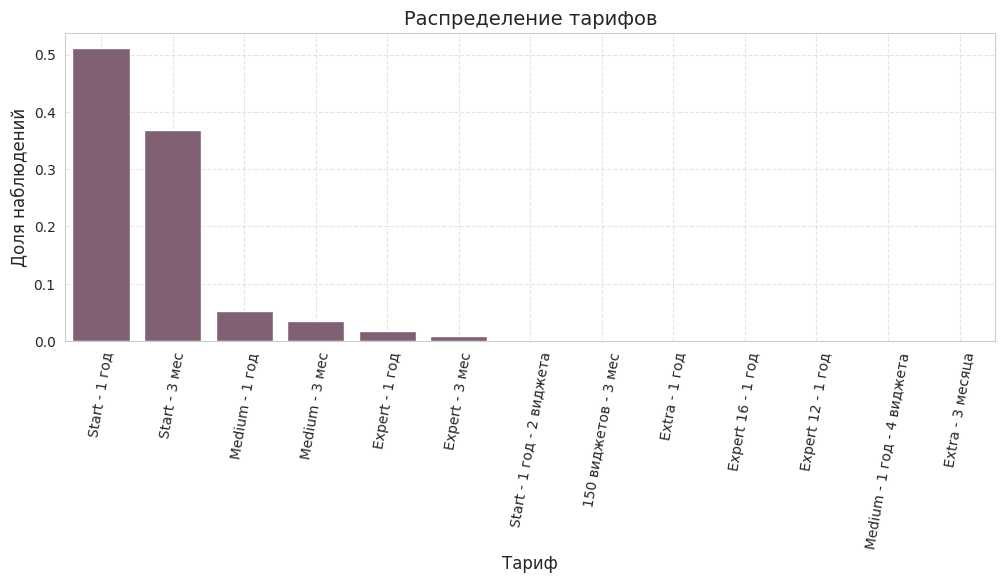

In [83]:
pp_bar = df_pp_success['name'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='name',
            y='proportion',
            data=pp_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение тарифов', fontsize=14)
plt.xlabel('Тариф', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.xticks(rotation=80)
plt.show()

Примерно такое же распределение, как в `details_plan_name`

Перейдём к таблице df_users

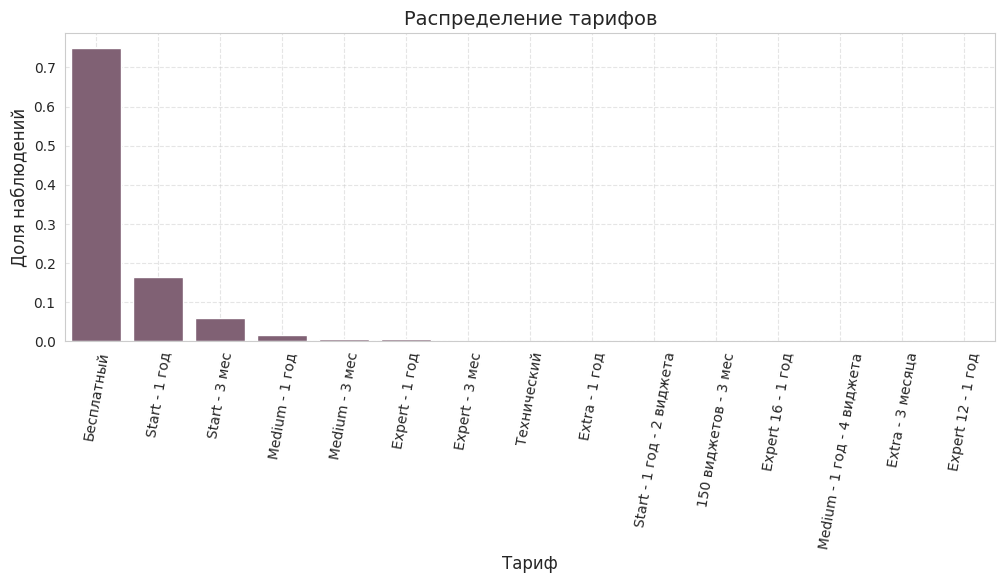

In [84]:
u_bar = df_users['plan_name'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='plan_name',
            y='proportion',
            data=u_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение тарифов', fontsize=14)
plt.xlabel('Тариф', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.xticks(rotation=80)
plt.show()

На момент анализа в базе данных зарегистрировано 5395 пользователей. Распределение по типам подписок выглядит следующим образом:

* Бесплатная подписка - 75% пользователей (около 4048 человек)
Это может включать как пользователей, завершивших пробный период и не продливших тариф, так и тех, кто перешел с платной версии на бесплатную
* Подписка Start 1 год - 16% пользователей (около 883 человек)
* Подписка Start 3 месяца - 6% пользователей (около 316 человек)
* Подписка Medium 1 год - 1.6% пользователей (около 85 человек)
* Подписка Medium 3 месяца - 0.4% пользователей (около 23 человек)
* Подписка Expert 1 год - 0.4% пользователей (23 человека)
* Подписка Expert 3 месяца - 0.09% пользователей (около 5 человек)


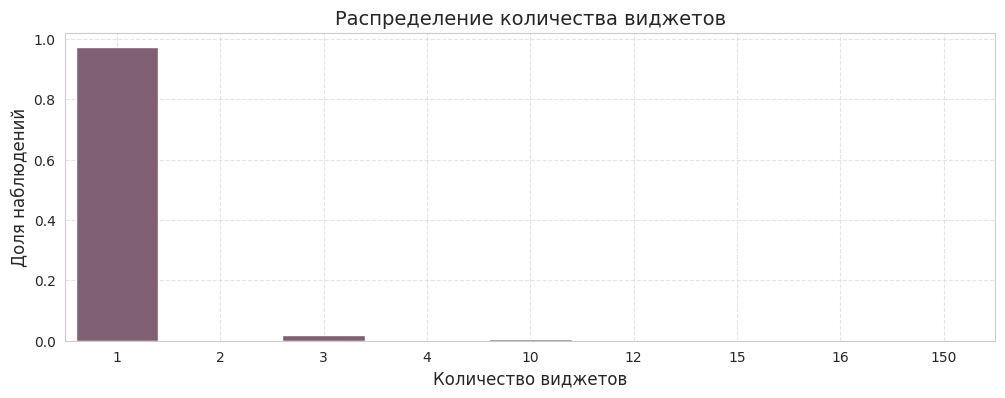

In [85]:
u_bar = df_users['plan_widgets_count'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='plan_widgets_count',
            y='proportion',
            data=u_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение количества виджетов', fontsize=14)
plt.xlabel('Количество виджетов', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

97% пользователей имеют доступ к 1 виджету, 2% - к 3 виджетам, 0.5% - к 10 виджетам.

Посмотрим на распределение количества виджета у активных пользователей

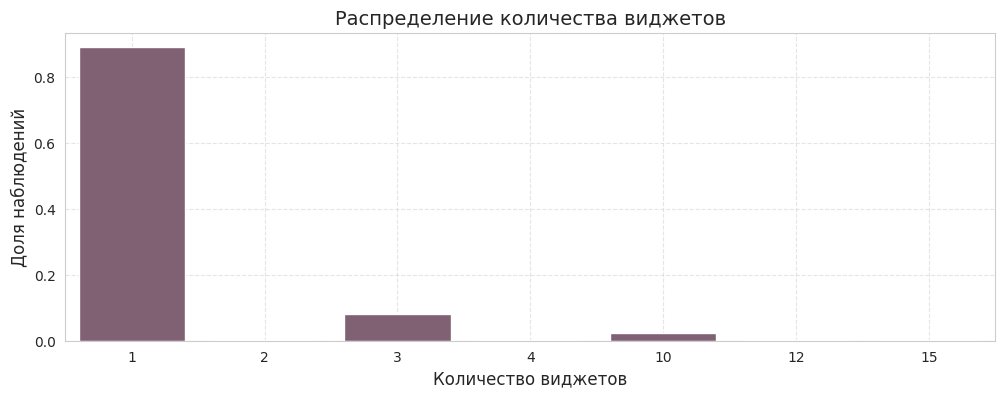

In [86]:
u_bar = df_users.query('plan_is_active == True')['plan_widgets_count'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='plan_widgets_count',
            y='proportion',
            data=u_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение количества виджетов', fontsize=14)
plt.xlabel('Количество виджетов', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

89% пользователей с активной подпиской имеют доступ к 1 виджету, 8% - к 3 виджетам, 2.4% - к 10 виджетам.

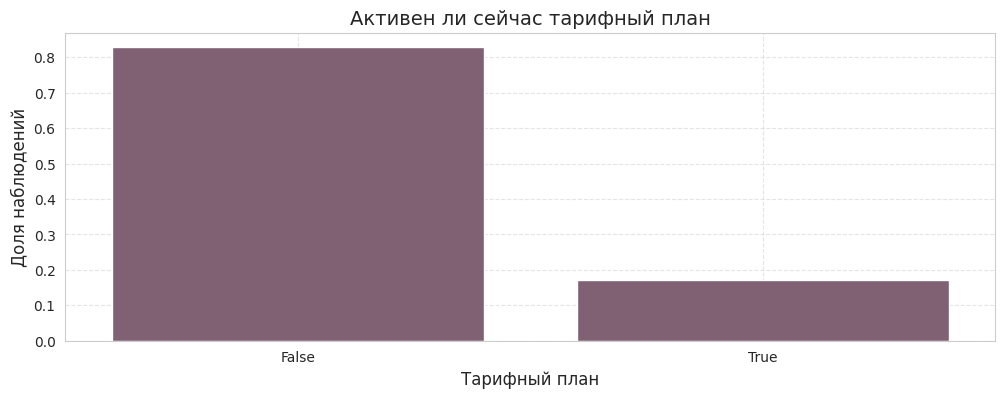

In [87]:
u_bar = df_users['plan_is_active'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='plan_is_active',
            y='proportion',
            data=u_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Активен ли сейчас тарифный план', fontsize=14)
plt.xlabel('Тарифный план', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

Доля активных тарифных планов составляет 17% от общего числа пользователей

Рассмотрим распределение триальных тарифных планов. Однако стоит учитывать, что в данных отсутствует 6% значений от общего числа строк датафрейма.

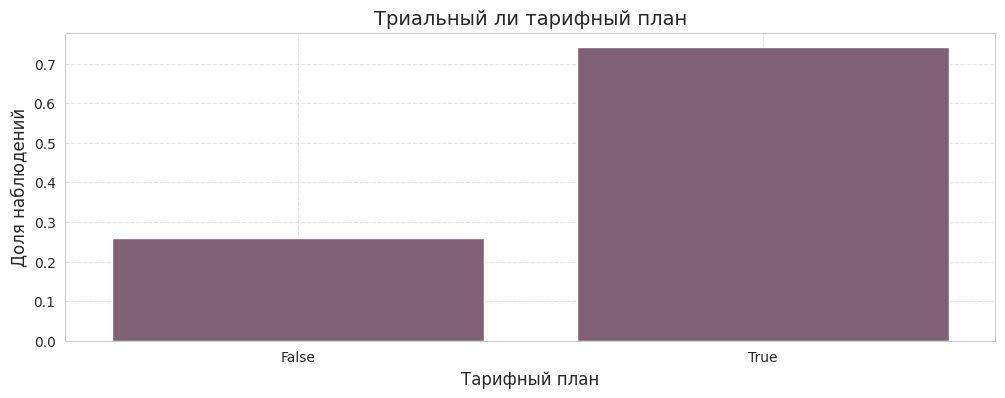

In [88]:
u_bar = df_users['plan_is_trial'].copy().dropna().astype(bool).value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='plan_is_trial',
            y='proportion',
            data=u_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Триальный ли тарифный план', fontsize=14)
plt.xlabel('Тарифный план', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

Доля пользователей с триальным тарифом составляет 73%, без него — 27%

Теперь перейдём к последнему датафрейму

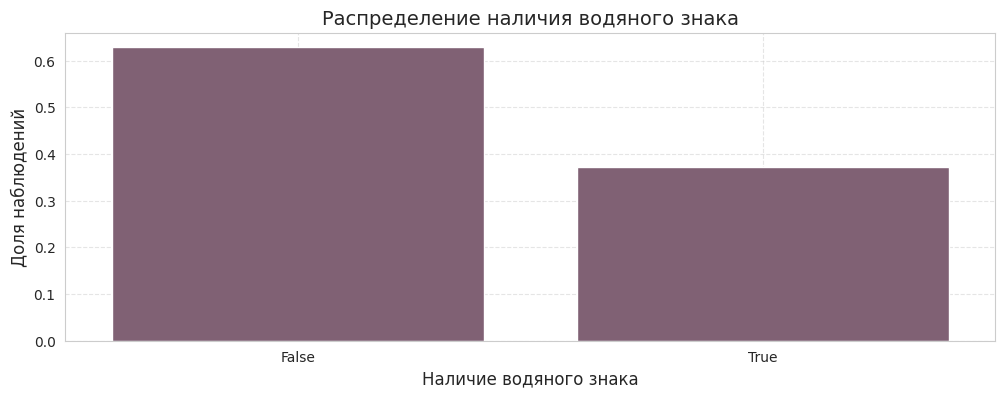

In [89]:
w_bar = df_widgets['hide_watermark'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='hide_watermark',
            y='proportion',
            data=w_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение наличия водяного знака', fontsize=14)
plt.xlabel('Наличие водяного знака', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

В нашей базе данных зарегистрировано 2178 виджетов. Распределение видимости водяных знаков следующее: 62% виджетов отображают водяной знак, 38% - имеют скрытый водяной знак.

Важно отметить, что возможность скрытия водяного знака доступна исключительно для пользователей с годовой подпиской.

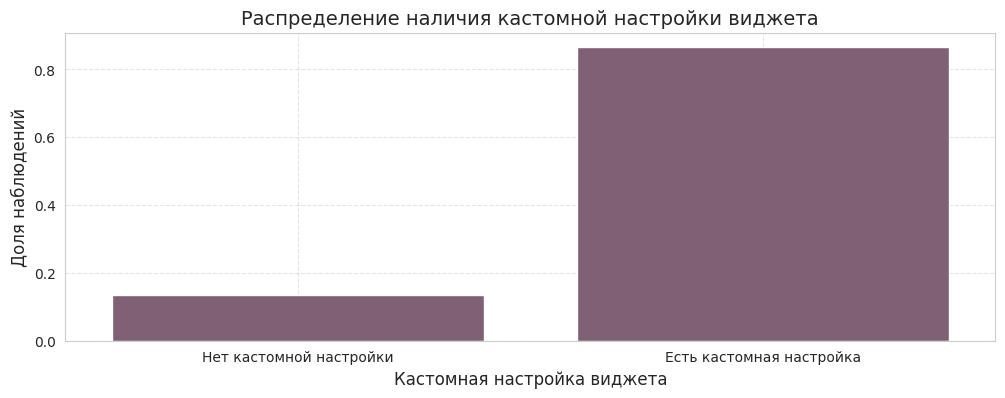

In [90]:
w_bar = df_widgets['is_custom_settings'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='is_custom_settings',
            y='proportion',
            data=w_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение наличия кастомной настройки виджета', fontsize=14)
plt.xlabel('Кастомная настройка виджета', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.xticks([0, 1], ['Нет кастомной настройки', 'Есть кастомная настройка'])
plt.show()

82% виджетов были настроены пользователями с помощью индивидуальных параметров через пользовательский интерфейс. Настройки позволяют настраивать отображение виджета, включая возможность скрывать или показывать определенные части контента, например, отзывы.

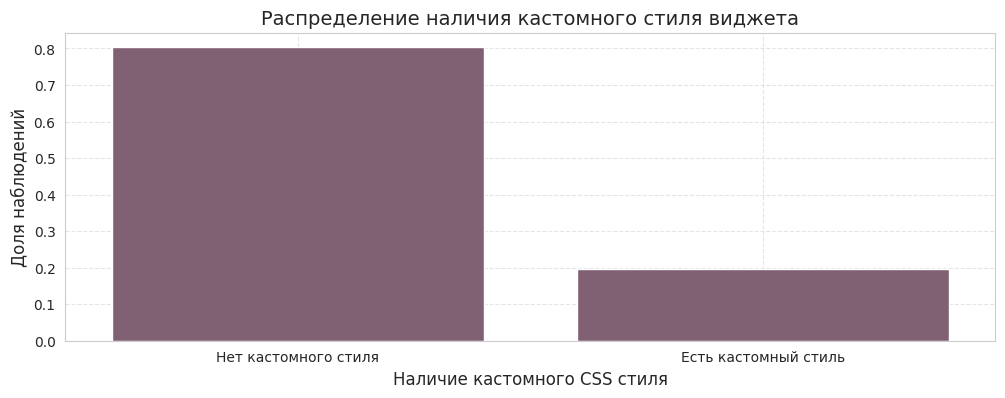

In [91]:
w_bar = df_widgets['is_custom_styles'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='is_custom_styles',
            y='proportion',
            data=w_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Распределение наличия кастомного стиля виджета', fontsize=14)
plt.xlabel('Наличие кастомного CSS стиля', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.xticks([0, 1], ['Нет кастомного стиля', 'Есть кастомный стиль'])
plt.show()

Для 80% виджетов не настроены CSS-стили, которые должны задаваться через админ-панель.

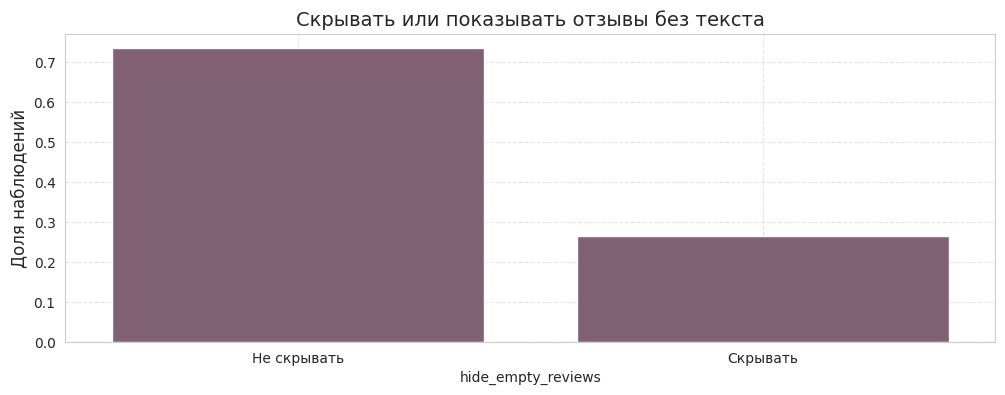

In [92]:
w_bar = df_widgets['hide_empty_reviews'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='hide_empty_reviews',
            y='proportion',
            data=w_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Скрывать или показывать отзывы без текста', fontsize=14)
#plt.xlabel('Наличие кастомного CSS стиля', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.xticks([False, True], ['Не скрывать', 'Скрывать'])
plt.show()

72% виджетов не скрывают отзывы без текста, тогда как 28% - скрывают.

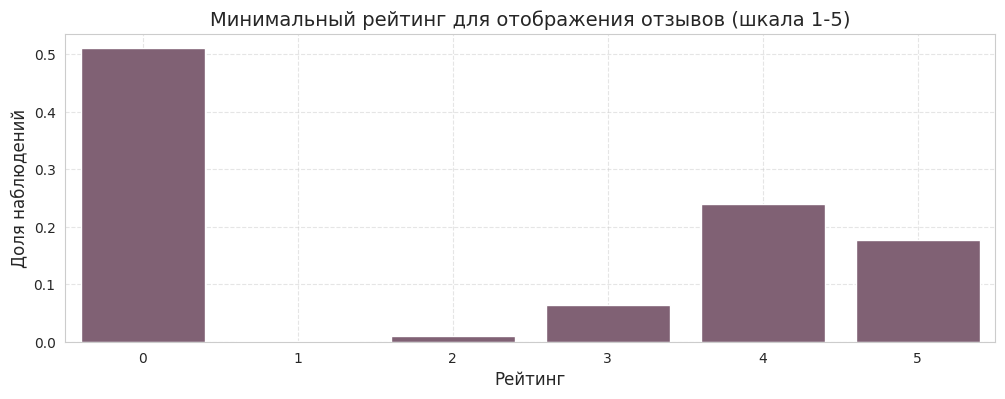

In [93]:
w_bar = df_widgets['rating_threshold'].value_counts(normalize=True).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x='rating_threshold',
            y='proportion',
            data=w_bar)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Минимальный рейтинг для отображения отзывов (шкала 1-5)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Доля наблюдений', fontsize=12)
plt.show()

* 51% - не скрывают отзывы с низким рейтингом

* 24% - скрывают отзывы с рейтингом ниже 4

* 17.6% - скрывают отзывы ниже 5

* 6.4% - скрывают отзывы ниже 3

* 0.096% - скрывают отзывы ниже 2

In [94]:
df_widgets.query('total_rating == 0')['total_rating'].count()

np.int64(239)

Посмотрим на распределение отзывов, у которых есть предрасчитанный рейтинг

In [95]:
t_r_copy = df_widgets.query('total_rating != 0')['total_rating'].copy()

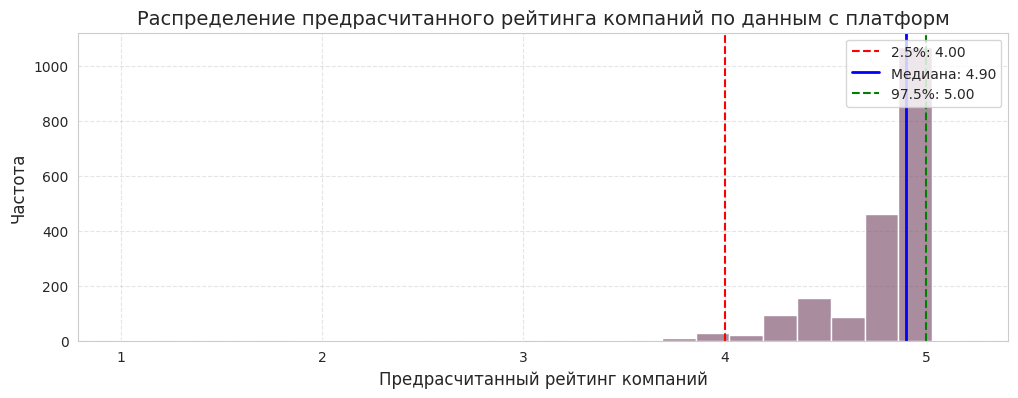

In [96]:
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=t_r_copy,
    bins=25,
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(t_r_copy, [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Распределение предрасчитанного рейтинга компаний по данным с платформ', fontsize=14)
ax1.set_xlabel('Предрасчитанный рейтинг компаний', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
plt.show()

* Около 239 виджетов имеют нулевой рейтинг

* Медианное значение предрасчитанного рейтинга: 4.9

* Наибольшая группа (около 1200 виджетов): рейтинг 5

* Только менее 2.5% виджетов имеют рейтинг ниже 4

In [97]:
df_widgets.query('total_review_amount == 0')['total_review_amount'].count()

np.int64(203)

In [98]:
t_r_am_copy = df_widgets.query('total_review_amount != 0')['total_review_amount'].copy()

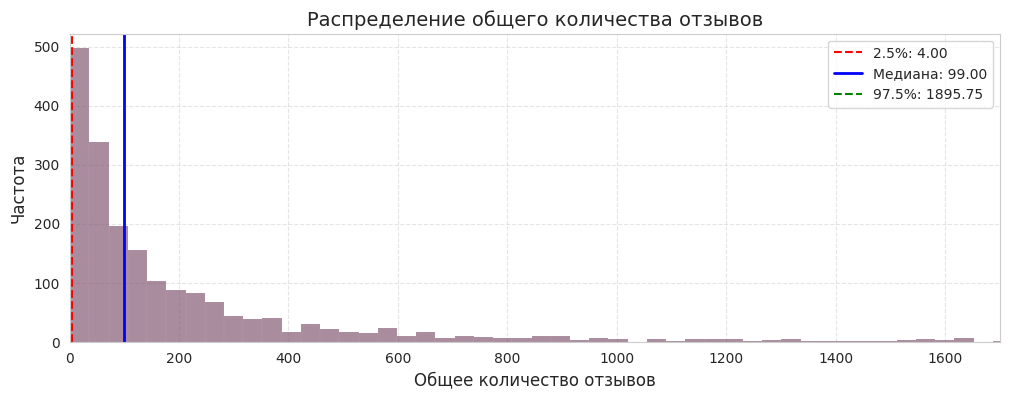

In [99]:
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=t_r_am_copy,
    bins='auto',
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(t_r_am_copy, [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Распределение общего количества отзывов', fontsize=14)
ax1.set_xlabel('Общее количество отзывов', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
plt.gca().set_xlim(0, 1700)
plt.show()

Распределение общего количества отзывов на виджетах имеет длинный хвост, достигающий примерно 60 000 отзывов. При этом:

* 203 виджета не имеют общего рейтинга.

* Только 2,5% виджетов содержат более 1 900 отзывов.

* Медиана распределения составляет 99 отзывов — это означает, что у половины виджетов общее количество отзывов меньше 99.

* Около 500 виджетов имеют около 30 виджетов.

* 2,5% отзывов в левой части распределения имеют значения меньше 4.

In [100]:
df_widgets.query('review_amount_double_gis == 0')['review_amount_double_gis'].count()

np.int64(1724)

In [101]:
dg_copy = df_widgets.query('review_amount_double_gis != 0')['review_amount_double_gis'].copy()

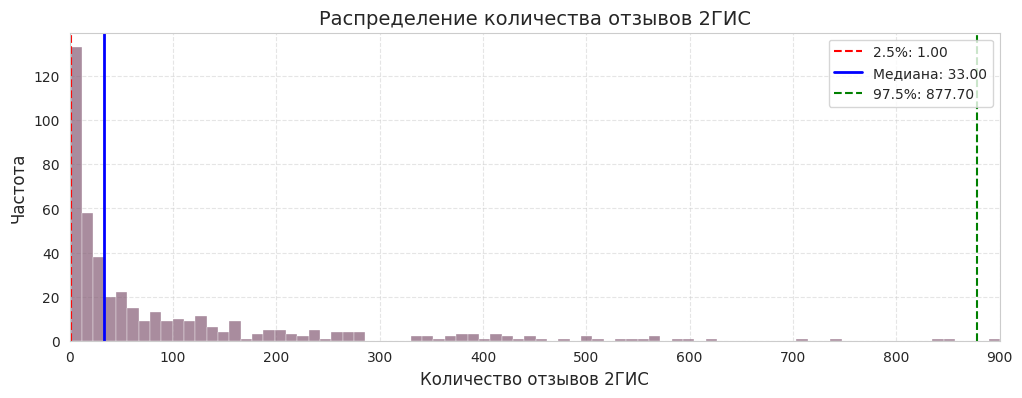

In [102]:
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=dg_copy,
    bins=250,
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(dg_copy, [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Распределение количества отзывов 2ГИС', fontsize=14)
ax1.set_xlabel('Количество отзывов 2ГИС', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
plt.gca().set_xlim(0, 900)
plt.show()

Распределение количества отзывов с 2ГИС имеет сильный перекос с длинным хвостом — максимальное значение достигает ~2 500 отзывов. Большинство виджетов не содержат отзывов с этой платформы (1 724 нулевых значения), что свидетельствует о редком использовании интеграции с 2ГИС. Среди виджетов, где отзывы присутствуют, медианное количество составляет 33 отзыва, при этом 95% значений находятся в диапазоне от 1 до 878 отзывов.

In [103]:
df_widgets.query('review_amount_vkontakte == 0')['review_amount_vkontakte'].count()

np.int64(1973)

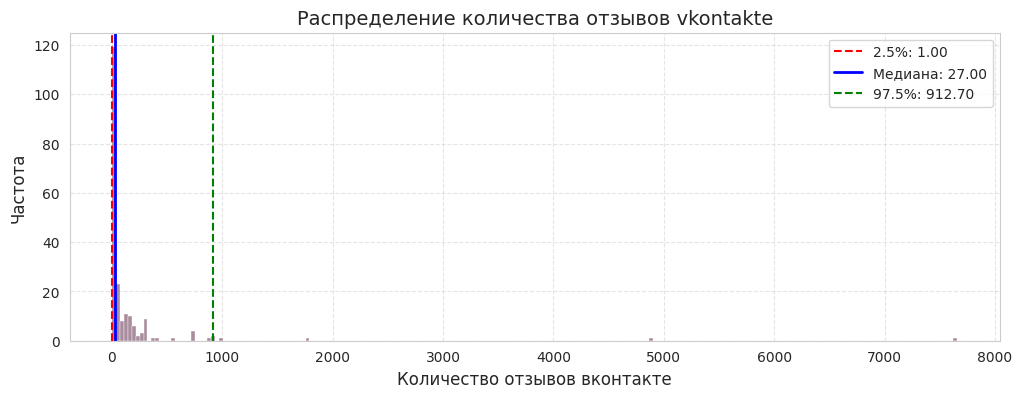

In [104]:
copy_v = df_widgets.query('review_amount_vkontakte != 0').copy()
copy_v['review_amount_vkontakte'] = pd.to_numeric(copy_v['review_amount_vkontakte'], errors='coerce')
copy_v = copy_v.dropna(subset=['review_amount_vkontakte'])

plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=copy_v,
    x='review_amount_vkontakte',
    bins='auto',
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(copy_v['review_amount_vkontakte'], [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Распределение количества отзывов vkontakte', fontsize=14)
ax1.set_xlabel('Количество отзывов вконтакте', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
plt.show()

Распределение отзывов из ВКонтакте также имеет значительный перекос с длинным хвостом — максимальное количество отзывов достигает 8 000. При этом в большинстве случаев отзывы отсутствуют: 1 973 виджетов не содержат ни одного отзыва. Среди виджетов с отзывами медианное значение составляет 27 отзывов, а 95% значений попадают в диапазон от 1 до 912 отзывов.

In [105]:
df_widgets.query('review_amount_avito == 0')['review_amount_avito'].count()

np.int64(1831)

У 1831 виджета нет отзывов с Авито. Давайте посмотрим, как распределяется количество отзывов на виджетах, где они есть.

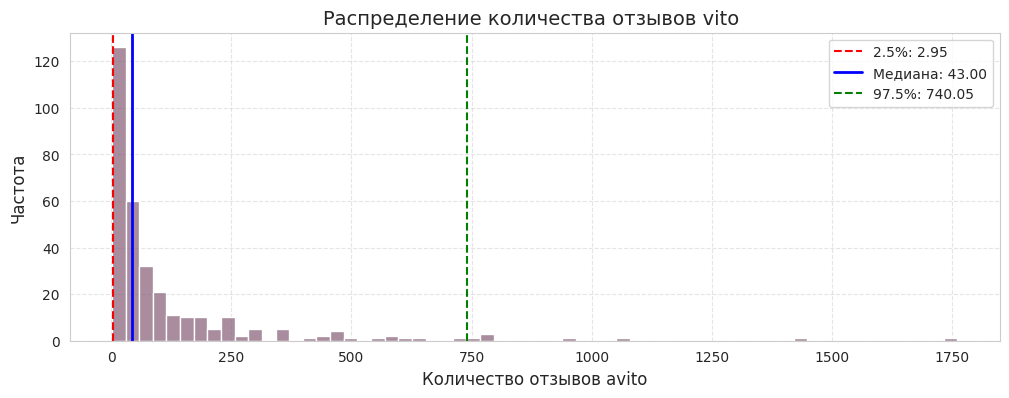

In [106]:
copy_a = df_widgets['review_amount_avito'].copy().dropna()
copy_a = copy_a[copy_a != 0]
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=copy_a,
    bins='auto',
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(copy_a, [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Распределение количества отзывов vito ', fontsize=14)
ax1.set_xlabel('Количество отзывов avito', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
#plt.gca().set_xlim(0, 237)
plt.show()

Анализ количества отзывов на виджеты с Авито показывает следующие результаты:

* 1831 виджет не имеет отзывов
* Медианное значение составляет 43 отзыва
* 95% всех значений находятся в диапазоне от 3 до 740 отзывов
* В данных присутствуют единичные выбросы, которые существенно отличаются от основной массы значений

In [107]:
df_widgets.query('review_amount_google_map == 0')['review_amount_google_map'].count()

np.int64(1424)

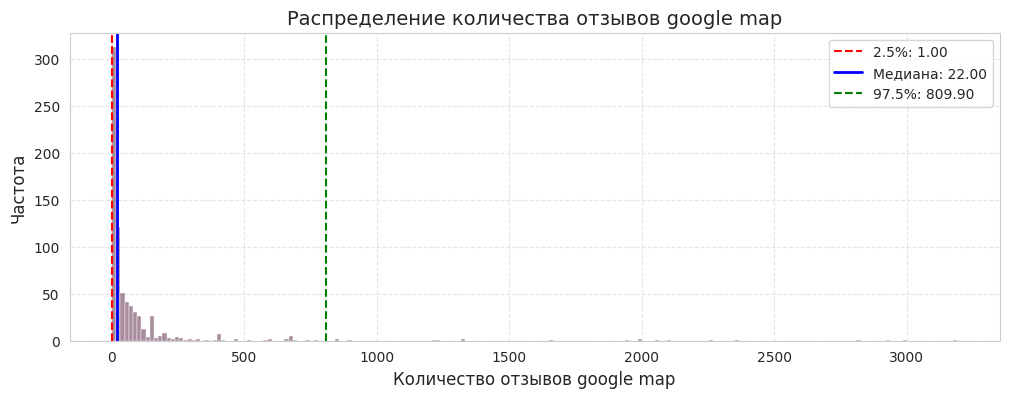

In [108]:
copy_gm = df_widgets['review_amount_google_map'].copy().dropna()
copy_gm = copy_gm[copy_gm != 0]
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=copy_gm,
    bins='auto',
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(copy_gm, [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Распределение количества отзывов google map', fontsize=14)
ax1.set_xlabel('Количество отзывов google map', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
#plt.gca().set_xlim(0, 237)
plt.show()

Аналогичное перекошенное распределение наблюдается и для отзывов с Google Maps, с длинным хвостом до ~3000 отзывов. При этом 1424 виджета вообще не содержат отзывов с этого сервиса. Среди виджетов, где отзывы присутствуют: медианное значение составляет 22 отзыва, а 95% значений попадают в диапазон от 1 до 810 отзывов.

In [109]:
df_widgets.query('review_amount_ya_sprav == 0')['review_amount_ya_sprav'].count()

np.int64(469)

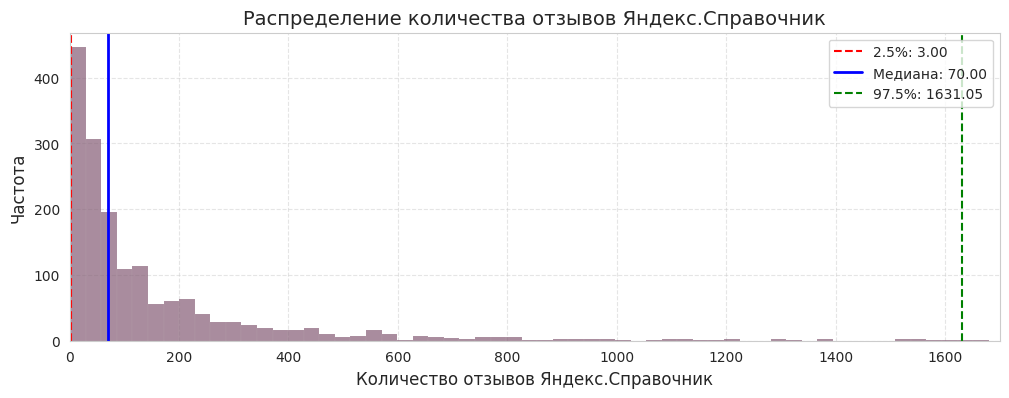

In [110]:
copy_ya = df_widgets['review_amount_ya_sprav'].copy().dropna()
copy_ya = copy_ya[copy_ya != 0]
plt.figure(figsize=(12, 4))
ax1 = plt.gca()

hist = sns.histplot(
    data=copy_ya,
    bins='auto',
    stat='count',
    alpha=0.7
)

p2_5, median, p97_5 = np.percentile(copy_ya, [2.5, 50, 97.5])

ax1.axvline(p2_5, color='red', linestyle='--', linewidth=1.5, label=f'2.5%: {p2_5:.2f}')
ax1.axvline(median, color='blue', linestyle='-', linewidth=2, label=f'Медиана: {median:.2f}')
ax1.axvline(p97_5, color='green', linestyle='--', linewidth=1.5, label=f'97.5%: {p97_5:.2f}')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_title('Распределение количества отзывов Яндекс.Справочник', fontsize=14)
ax1.set_xlabel('Количество отзывов Яндекс.Справочник', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.legend(loc='upper right')
plt.gca().set_xlim(0, 1700)
plt.show()

Для Яндекс.Справочника наблюдается следующая картина: только 469 виджетов из 2173 не содержат отзывов (в данных присутствует 5 пропущенных значений при общем количестве 2178 строк). Распределение количества отзывов имеет сильный перекос с экстремально длинным хвостом - максимальное значение достигает 60 000 отзывов. Медианное значение составляет 70 отзывов, при этом 95% наблюдений (исключая по 2,5% с каждого конца распределения) находятся в диапазоне от 3 до 1 630 отзывов.

Посмотрим как менялось со временем количество зарегестрированных пользователей

<ipython-input-111-94d8acabc57b>:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  kek_us['quarter'] = kek_us.index.to_period('Q').astype(str)


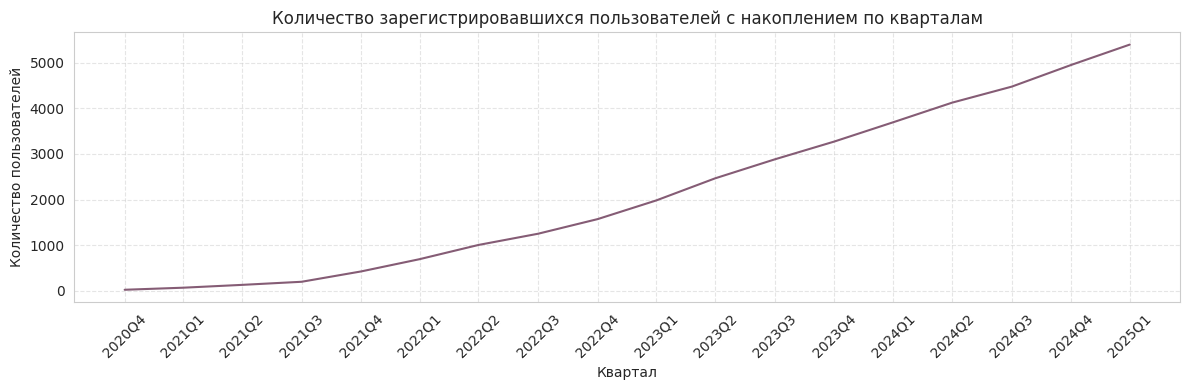

In [111]:
df_success_us = df_users[['created_at', 'user_id']].copy().sort_values('created_at')
df_success_us = df_success_us.set_index('created_at')
df_success_us['user_id'] = 1

kek_us = df_success_us.resample('QE').sum().cumsum()

kek_us['quarter'] = kek_us.index.to_period('Q').astype(str)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kek_us.index, kek_us['user_id'])

ax.set_xticks(kek_us.index)
ax.set_xticklabels(kek_us['quarter'], rotation=45)

plt.title('Количество зарегистрировавшихся пользователей с накоплением по кварталам')
plt.ylabel('Количество пользователей')
plt.xlabel('Квартал')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

С четвертого квартала 2020 года количество зарегистрированных пользователей на сайте превысило 5000 человек. До третьего квартала 2021 года наблюдался умеренный рост пользовательской базы, после чего динамика значительно улучшилась.

С первого квартала 2023 г. фиксируется стабильный рост числа зарегистрированных пользователей с накоплением. График демонстрирует Стабильную положительную динамику, что свидетельствует о стабильном расширении пользовательской базы платформы.

**Общий вывод:**

Статистика платежей

Согласно данным логов:
* 64% платежей успешны, 36% — отменены.
* Основной диапазон выручки за платёж: от 450 до 2500 рублей. В этом интервале сосредоточена большая часть значений.
* Распределение платежей скошено влево и имеет длинный хвост, достигающий 26 000 рублей, что указывает на очень редкие крупные платежи.
* Только 2,5% платежей превышают сумму 5350 рублей
* Медиана 2100 руб. (Медианная стоимость проданных тарифов составляет 2490 рублей)

Распределение продаж по тарифам
* Start 1 год — 51% продаж
* Start 3 месяца — 37%
* Medium 1 год — 5%
* Medium 3 месяца — 3.5%
* Expert 1 год — 1.5%
* Expert 3 месяца — 0.7%

Соотношение сроков подписки:
* 58% покупок приходится на годовые тарифы,
* 42% — 3-месячные.

Распределение по количеству виджетов
* 86% продаж — тарифы с 1 виджетом,
* 10% — с 3 виджетами,
* 3% — с 10 виджетами,
* 1% — остальные тарифы.

Статистика пользователей

На момент выгрузки в базе данных зарегистрировано 5 395 пользователей с стабильным ежеквартальным приростом примерно 400–450 пользователей. Такой рост сохраняется начиная с первого квартала 2023 года.

Распределение по подпискам:

* Бесплатная подписка: 75% пользователей (~4 040 человек)
* Start 1 год: 16% (~863 человека)
* Start 3 месяца: 6% (~324 человека)
* Medium 1 год: 1,6% (~86 человек)
* Medium 3 месяца: 0,4% (~22 человека)
* Expert 1 год: 0,4% (~22 человека)
* Expert 3 месяца: 0,09% (~5 человек)

Доступные виджеты:

Среди всех пользователей:
* 97% имеют доступ к 1 виджету (включая неактивных).
* 2% — к 3 виджетам.
* 0,5% — к 10 виджетам.

Среди активных пользователей:
* 89% — 1 виджет.
* 8% — 3 виджета.
* 2,4% — 10 виджетов.

Дополнительная статистика:
* Доля активных тарифных планов: 17% от общего числа пользователей.

Триальные тарифы:
* 6% данных отсутствуют (пропуски).
* Без учёта пропусков: 73% — триальные, 27% — нет.

Статистика виджетов

В таблице представлены данные о 2 178 виджетах.

Настройки виджетов:

Водяные знаки:
* 62% — отображают водяной знак,
* 38% — скрывают водяной знак (доступно только для пользователей с годовой подпиской).

Настройки CSS: у 80% виджетов данные отсутствуют.

Пользовательские настройки: у 18% виджетов информация не указана.

Фильтрация отзывов:

Без текста:
* 72% — не скрывают,
* 28% — скрывают.

С низким рейтингом:
* 51% — не скрывают,
* 24% — скрывают отзывы с рейтингом ниже 4,
* 17,6% — ниже 5,
* 6,4% — ниже 3.

Рейтинги:

239 виджетов имеют нулевой предрасчитанный рейтинг.

Распределение предрасчитанных рейтингов:
* Медиана: 4,9,
* Менее 2,5% виджетов имеют рейтинг ниже 4.

203 виджета не имеют общего рейтинга.

Среди остальных:
* 2,5% имеют более 1 900 отзывов,
* Медиана: 99 отзывов,
* Около 500 виджетов имеют ~30 отзывов.

Отзывы с платформ:

| Платформа           | Виджеты с отзывами  | Медиана отзывов | 95% диапазон     |
|---------------------|---------------------|-----------------|------------------|
| 2ГИС                | 454 (20,8%)          | 33              | 1 – 878          |
| ВКонтакте           | 205 (9,5%)           | 27              | 1 – 912          |
| Авито               | 347 (15,9%)          | 43              | 3 – 740          |
| Google Maps         | 754 (34,6%)          | 22              | 1 – 810          |
| Яндекс.Справочник   | 1 700 (78%)          | 70              | 3 – 1 630        |

### Финансовый анализ

In [112]:
df_success = df_payments_plans.query('status == "SUCCEEDED"')[['created_at', 'details_amount']].copy().sort_values('created_at')
df_success = df_success.set_index('created_at')

<ipython-input-113-2f27b812d490>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  kek['quarter'] = kek.index.to_period('Q').astype(str)


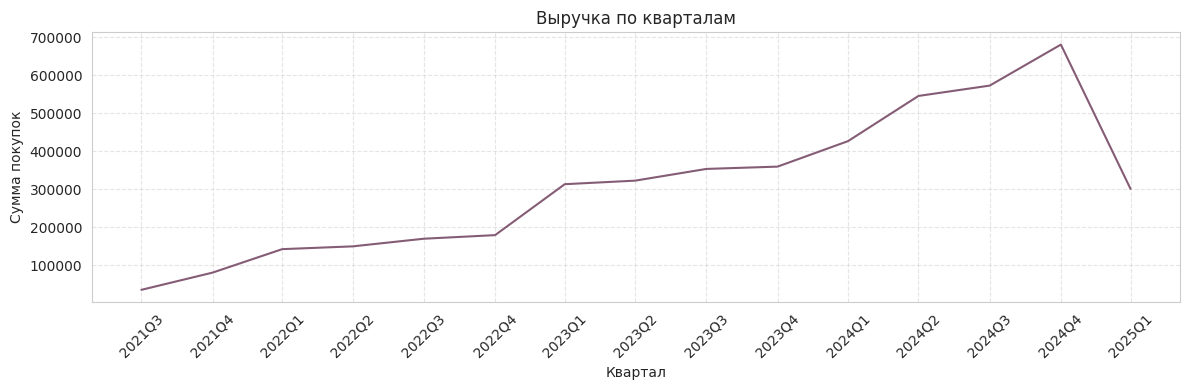

In [113]:
kek = df_success.copy().resample('QE').sum()

kek['quarter'] = kek.index.to_period('Q').astype(str)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kek.index, kek['details_amount'])

ax.set_xticks(kek.index)
ax.set_xticklabels(kek['quarter'], rotation=45)

plt.title('Выручка по кварталам')
plt.ylabel('Сумма покупок')
plt.xlabel('Квартал')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [114]:
df_payments_plans['created_at'].max()

Timestamp('2025-02-10 19:40:11.380000+0300', tz='Europe/Moscow')

За исключением первого квартала 2025 года (по которому имеются данные только за его половину), выручка компании демонстрирует стабильный рост. За последние три года квартальная выручка увеличилась с 100 тысяч до почти 700 тысяч рублей.

<ipython-input-115-22a9d55fd5e1>:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  kek_mean['quarter'] = kek_mean.index.to_period('Q').astype(str)


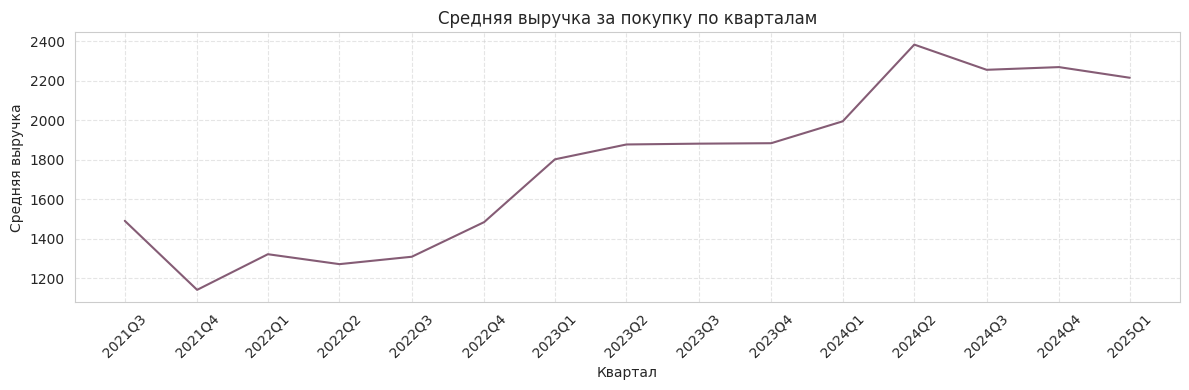

In [115]:
kek_mean = df_success.copy().resample('QE').mean()

kek_mean['quarter'] = kek_mean.index.to_period('Q').astype(str)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(kek_mean.index, kek_mean['details_amount'])

ax.set_xticks(kek_mean.index)
ax.set_xticklabels(kek_mean['quarter'], rotation=45)

plt.title('Средняя выручка за покупку по кварталам')
plt.ylabel('Средняя выручка')
plt.xlabel('Квартал')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

График отражает динамику изменения средней выручки за покупку по кварталам.

С 3-го квартала 2022 года по 1-й квартал 2023 года наблюдался сначала плавный, а затем более резкий рост средней выручки за покупку. После этого динамика выручки стабилизировалась.

Аналогичная ситуация с ростом произошла в 4-м квартале 2023 года, а пиковое значение средней выручки было достигнуто во 2-м квартале 2024 года — около 2400 руб. за покупку в среднем.

Затем последовал небольшой спад с последующей стабилизацией на уровне 2200–2300 руб. за покупку.

Рассмотрим квартальную динамику изменения ARPPU по 6 основным тарифам.

In [116]:
filtered_tariffs = [
    'Start - 1 год', 'Start - 3 мес',
    'Medium - 1 год', 'Medium - 3 мес',
    'Expert - 1 год', 'Expert - 3 мес'
]

In [117]:
arpu_df = df_pp_success.query('details_plan_name in @filtered_tariffs')[['created_at', 'details_plan_name', 'user_id', 'details_amount']].copy()

In [118]:
arpu_df['created_at'] = pd.to_datetime(arpu_df['created_at'])
arpu_df['quarter'] = arpu_df['created_at'].dt.to_period('Q')

revenue = arpu_df.groupby(['quarter', 'details_plan_name'])['details_amount'].sum()
users = arpu_df.groupby(['quarter', 'details_plan_name'])['user_id'].nunique()

arpu_by_tariff_quarter = (revenue / users).reset_index(name='ARPU')

<ipython-input-118-855bbe48abef>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  arpu_df['quarter'] = arpu_df['created_at'].dt.to_period('Q')


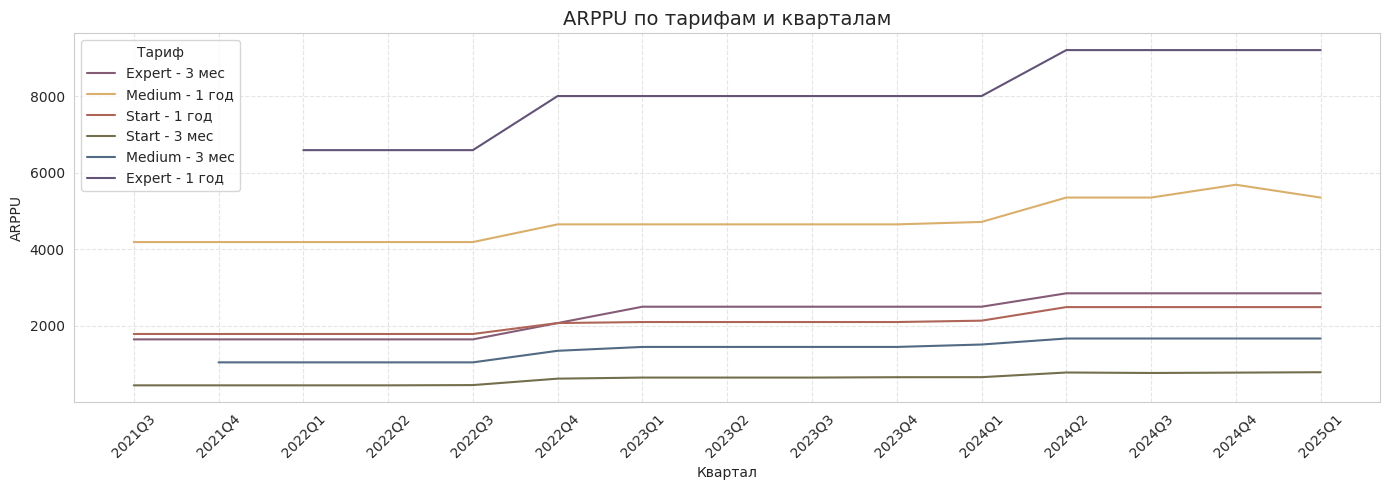

In [119]:
arpu_by_tariff_quarter['quarter'] = arpu_by_tariff_quarter['quarter'].astype(str)

plt.figure(figsize=(14, 5))
sns.lineplot(
    data=arpu_by_tariff_quarter,
    x='quarter',
    y='ARPU',
    hue='details_plan_name'
)

plt.title('ARPPU по тарифам и кварталам', fontsize=14)
plt.xlabel('Квартал')
plt.ylabel('ARPPU')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title='Тариф')
plt.show()

In [120]:
arpu_pupu = arpu_by_tariff_quarter.pivot_table(index='quarter', columns='details_plan_name', values='ARPU')

In [121]:
arpu_growth = arpu_pupu.pct_change() * 100


<ipython-input-121-88a822b89c9f>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  arpu_growth = arpu_pupu.pct_change() * 100


In [122]:
arpu_growth.loc['2023Q1':].round(2)

details_plan_name  Expert - 1 год  Expert - 3 мес  Medium - 1 год  \
quarter                                                             
2023Q1                        0.0           51.79            0.00   
2023Q2                        0.0            0.00            0.00   
2023Q3                        0.0            0.00            0.00   
2023Q4                        0.0            0.00            0.00   
2024Q1                        0.0            0.00            1.37   
2024Q2                       15.0           14.00           13.50   
2024Q3                        0.0            0.00            0.00   
2024Q4                        0.0            0.00            6.25   
2025Q1                        0.0            0.00           -5.88   

details_plan_name  Medium - 3 мес  Start - 1 год  Start - 3 мес  
quarter                                                          
2023Q1                       7.47           1.28           4.52  
2023Q2                       0.00           0.00           0.00  
2023Q3                       0.00           0.00           0.00  
2023Q4                       0.00           0.00           1.43  
2024Q1                       4.33           1.70           0.20  
2024Q2                      10.39          16.59          18.41  
2024Q3                       0.00           0.00          -1.56  
2024Q4                       0.00           0.00           1.19  
2025Q1                       0.00           0.00           1.36

Динамика ARPPU по тарифам во II квартале 2024 года и последующие периоды

Тариф Expert – 1 год
Средняя квартальная выручка (ARPPU) во II квартале 2024 года выросла на 15% и составила 9 200 руб. После роста колебаний не наблюдалось.

Тариф Expert – 3 мес.
Во II квартале 2024 года ARPPU увеличился на 14%, достигнув 2 850 руб., после чего показатель оставался стабильным.

Тариф Medium – 1 год
Во II квартале 2024 года ARPPU вырос на 13,5%, составив 5 350 руб. В IV квартале 2024 года показатель повысился на 6,25%, но в I квартале 2025 года вернулся к уровню III квартала 2024 года (5 350 руб.).

Тариф Medium – 3 мес.
Во II квартале 2024 года ARPPU увеличился на 10,4%, достигнув 1 670 руб., и в дальнейшем не изменялся.

Тариф Start – 1 год
Во II квартале 2024 года ARPPU вырос на 16,6%, составив 2 490 руб., и оставался стабильным в последующих периодах.

Тариф Start – 3 мес.
Во II квартале 2024 года ARPPU вырос на 18,4% (782 руб.). Далее динамика была следующей:

Снижение на 1,5% (III квартал 2024);

Рост на 1,2% (IV квартал 2024);

Дополнительный рост на 1,36% (первая половина I квартала 2025).
В итоге показатель достиг 790 руб.

In [123]:
df_crr = df_pp_success.copy()

In [124]:
df_crr['row_number'] = df_crr.sort_values('created_at').groupby(['user_id']).cumcount() + 1

In [125]:
df_cr_us = df_crr.pivot_table(index='row_number', values='user_id', aggfunc='count')

In [126]:
test = pd.DataFrame([{'user_id' : df_users.shape[0]}])

In [127]:
df_stack = pd.concat([test, df_cr_us])

In [128]:
df_stack['share_user'] = (df_stack['user_id'] / df_users.shape[0]).round(2)
df_stack['cr'] = (df_stack['user_id'] / df_stack['user_id'].shift(1)).round(2)
df_stack.loc[0, 'cr'] = 1

In [129]:
df_stack = df_stack[:6].copy()

In [130]:
df_stack["stage"] = [
    "Регистрация", "Первая покупка", "Вторая покупка",
    "Третья покупка", "Четвёртая покупка", "Пятая покупка"
]

fig = px.funnel(df_stack,
                y="stage",
                x="user_id",
                title="Воронка пользователей от регестрации до пятой покупки",
                labels={"user_id": "Доля пользователей", "stage": "Этап"})

fig.show()

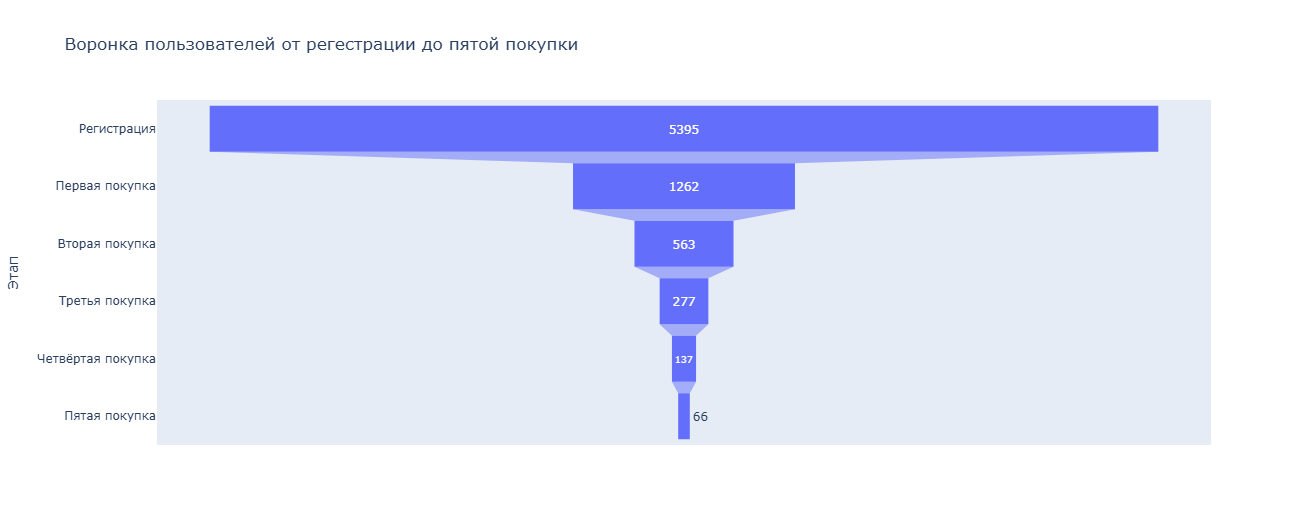

In [131]:
df_stack

user_id  share_user    cr              stage
0     5395        1.00  1.00        Регистрация
1     1262        0.23  0.23     Первая покупка
2      563        0.10  0.45     Вторая покупка
3      277        0.05  0.49     Третья покупка
4      137        0.03  0.49  Четвёртая покупка
5       66        0.01  0.48      Пятая покупка

Показатель Conversion Rate (CR) на разных этапах:

* От регистрации до первой покупки — 23%,
* От первой покупки до второй — 45%,
* От второй до третьей — 49%.

Такая динамика сохраняется вплоть до пятой покупки. При этом пятую покупку совершили 66 пользователей, что составляет около 1% от общего числа зарегистрированных.

**Общий вывод:**

**Финансовые показатели компании:**

За исключением первого квартала 2025 года, по которому доступны данные только за первую половину, выручка компании демонстрирует устойчивый рост. За последние три года квартальная выручка увеличилась с 100 тыс. до почти 700 тыс. рублей.

**Динамика средней выручки за покупку:**

С третьего квартала 2022 года по первый квартал 2023 года наблюдался сначала умеренный, а затем более стремительный рост этого показателя. После этого темпы роста стабилизировались.

Аналогичная картина повторилась в четвёртом квартале 2023 года. Пиковое значение средней выручки за покупку было достигнуто во втором квартале 2024 года — около 2 400 руб. Далее последовало незначительное снижение, с последующей стабилизацией на уровне 2 200–2 300 руб.

**Динамика ARPU по тарифам во II квартале 2024 года и далее:**

* Expert – 1 год: ARPU во II квартале 2024 года вырос на 15% и составил 9 200 руб. После этого изменений не наблюдалось.
* Expert – 3 мес.: Рост на 14%, до 2 850 руб. Показатель остался стабильным.
* Medium – 1 год: Во II квартале 2024 года ARPU увеличился на 13,5%, до 5 350 руб. В IV квартале произошло дополнительное увеличение на 6,25%, однако в I квартале 2025 года показатель вернулся к уровню III квартала 2024 года — 5 350 руб.
* Medium – 3 мес.: Рост на 10,4%, до 1 670 руб., после чего значение оставалось неизменным.
* Start – 1 год: Увеличение ARPU на 16,6% во II квартале 2024 года, до 2 490 руб. Показатель остался стабильным в последующих периодах.
* Start – 3 мес.: Рост ARPU на 18,4%, до 782 руб. Далее динамика была следующей:

    * снижение на 1,5% в III квартале 2024 года;
    * рост на 1,2% в IV квартале;
    * дополнительное увеличение на 1,36% в первой половине I квартала 2025 года. В результате ARPU достиг 790 руб.

**Конверсия (Conversion Rate, CR):**
* От регистрации до первой покупки — 23%;
* От первой до второй покупки — 45%;
* От второй до третьей — 49%.

Такая динамика сохраняется вплоть до пятой покупки. Пятую покупку совершили 66 пользователей, что составляет около 1% от общего числа зарегистрированных.


## Статистический анализ

Исследуем, влияет ли количество отзывов компании на выбор тарифа

Возьмём третий квартиль в качестве границы для разделения на группы. В первую группу войдут данные о покупках виджетов, у которых количество отзывов меньше 75% (ниже третьего квартиля), а во вторую — о покупках виджетов с количеством отзывов больше 75% (выше третьего квартиля). Затем проверим, есть ли статистически значимые различия в популярности тарифов в зависимости от общего количества отзывов на виджете, который приобретает компания.

In [132]:
print(f"75-й перцентиль: {np.percentile(df_widgets.query('total_review_amount != 0')['total_review_amount'], 75)}")

75-й перцентиль: 256.5


In [133]:
q_t = df_widgets.query('total_review_amount >= 257').copy()
q_t_df = pd.merge(q_t, df_pp_success, how='inner', on='user_id')

In [134]:
q_t_df_unique_payments = q_t_df.drop_duplicates(subset=['payment_id'])

In [135]:
print(f"Размер выборки: {q_t_df_unique_payments.shape[0]}")

Размер выборки: 726


In [136]:
group_25 = q_t_df_unique_payments['name'].value_counts().sort_values(ascending=False)

In [137]:
qq_t = df_widgets.query('total_review_amount < 257').copy()
qq_t_df = pd.merge(qq_t, df_pp_success, how='inner', on='user_id')

In [138]:
q_t_df_up = qq_t_df.drop_duplicates(subset=['payment_id'])

In [139]:
print(f"Размер выборки: {q_t_df_up.shape[0]}")

Размер выборки: 1413


In [140]:
group_75 = q_t_df_up['name'].value_counts().sort_values(ascending=False)

In [141]:
test_a = group_25[:'Expert - 3 мес'].reset_index().sort_values('name')

In [142]:
test_b = group_75[:'Expert - 3 мес'].reset_index().sort_values('name')

* H0: Общее количество отзывов не влияет на выбор тарифа
* H1: Общее количество отзывов влияет на выбор тарифа

In [143]:
a = 0.05 / 6

In [144]:
for n, h, k in zip(test_a['name'], test_a['count'], test_b['count']):
    _, pval = proportions_ztest([h, k], [726, 1413])
    print('- * ' * 20)
    print('Сравниваем пропорции для тарифа:', n)
    print(pval)
    if pval < a:
        print('Отвергаем нулевую гипотезу: между пропорциями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными')

- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
Сравниваем пропорции для тарифа: Expert - 1 год
0.2677630200557015
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
Сравниваем пропорции для тарифа: Expert - 3 мес
0.8325923468912456
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
Сравниваем пропорции для тарифа: Medium - 1 год
0.8064144235917379
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * 
Сравниваем пропорции для тарифа: Medium - 3 мес
0.22957711014084725
Не получилось отвергнуть нулевую гипотезу, нет оснований считать пропорции разными
- * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - * - *

Не удалось отвергнуть нулевую гипотезу об отсутствии различий в выборе тарифа между компаниями, имеющими меньше 267 отзывов (75% виджетов), и компаниями с более 267 отзывами (25% виджетов). Все тесты показали статистически незначимые результаты.

## Сравнение тарифных линеек конкурентов

**Таблица с тарифами SmartWidgets**

Цены указаны для годовой подписки с экономией 17%. Цены указаны в рублях за один месяц.

| Тариф     | Цена     | Особенности                                                                 |
|-----------|----------|------------------------------------------------------------------------------|
| Free      | 0 ₽      | - 300 показов/месяц  <br> - 1 виджет  <br> - Любое количество сайтов  <br> - Только исправление ошибок  <br> - Логотип SmartWidgets |
| Lite      | 499 ₽    | - 3 000 показов/месяц  <br> - 3 виджета  <br> - Любое количество сайтов  <br> - Онлайн-поддержка  <br> - Помощь с установкой  <br> - Без логотипа |
| Business  | 999 ₽    | - 30 000 показов/месяц  <br> - 20 виджетов  <br> - Любое количество сайтов  <br> - Онлайн-поддержка  <br> - Помощь с установкой  <br> - Без логотипа |
| Pro       | 1999 ₽   | - Безлимитные показы  <br> - Аналитика + API  <br> - 50 виджетов и 3 сайта  <br> - Премиум поддержка  <br> - Помощь с установкой  <br> - Без логотипа |


**Таблица тарифов Elfsight**

| План      | Цена ($/мес) | Просмотры  | Виджеты | Проекты | Перевод отзывов ИИ | Продвинутые настройки | Установка | Поддержка                  | Без рекламы |
|-----------|---------------|------------|---------|----------|----------------------|-------------------------|-----------|----------------------------|--------------|
| Free      | 0             | 200        | 1       | 0        | ❌                   | ❌                      | ❌        | Только исправление ошибок | ❌           |
| Basic     | 10            | 5,000      | 3       | 0        | ❌                   | ✅                      | ✅        | Базовая поддержка         | ✅           |
| Pro       | 20            | 50,000     | 9       | 3        | ✅                   | ✅                      | ✅        | Приоритетная поддержка    | ✅           |
| Premium   | 40            | 150,000    | 21      | 9        | ✅                   | ✅                      | ✅        | Приоритет + Live Chat     | ✅           |


**Таблица тарифов Goodvice**

| Функция / Тариф            | FREE (0 р)               | Старт                    | Корпоративный            |
|----------------------------|--------------------------|--------------------------|--------------------------|
| Мониторинг отзывов (14 источников) | ✅                      | ✅                       | ✅                       |
| Уведомление о новых отзывах на почту | ✅                      | ✅                       | ✅                       |
| Мотивационные рассылки      | ❌                       | ✅                       | ✅                       |
| Отчеты по источникам и рассылкам | ❌                       | ✅                       | ✅                       |
| Интеграция с CRM            | ❌                       | ✅                       | ✅                       |
| Виджет для сайта            | ❌                       | ✅                       | ✅                       |
| Настройка под ключ          | ❌                       | ✅                       | ✅                       |
| Персональный менеджер       | ❌                       | ❌                       | ✅                       |
| Добавление индивидуальных источников | ❌                       | ❌                       | ✅                       |
| Количество филиалов         | 1                        | 1                        | Индивидуально            |
| Пробный период             | 7 дней                   | -                        | -                        |
| Стоимость                   | Бесплатно                | Уточняется               | Уточняется               |


Таблица тарифов **myreviews**

Цены указаны при покупке на год

Помесячно: 312; 570; от 999

| Функция / Тариф               | Start (219 ₽/мес)        | Smart (399 ₽/мес)        | Business (от 699 ₽/мес)  |
|-------------------------------|--------------------------|--------------------------|--------------------------|
| **Цена**                      | 219 ₽/мес               | 399 ₽/мес               | от 699 ₽/мес            |
| **Количество филиалов**       | 1                       | до 10                    | Неограниченно           |
| **Индексы отзывов**           | Только всплывающий      | Все виды                 | Все виды                |
| **Страницы сбора отзывов**    | Стандартная             | Настраиваемые            | Настраиваемые           |
| **Обновление отзывов**        | Ежедневно               | Ежедневно                | Онлайн                  |
| **Перехват негативных отзывов** | ✅                      | ✅                       | ✅                      |
| **Уведомления**               | Telegram и почта        | Telegram и почта         | Telegram и почта        |
| **Количество геосервисов**    | Неограниченно           | Неограниченно            | Неограниченно           |
| **Анализ конкурентов**        | ❌                      | ❌                       | ✅                      |
| **Расширенная аналитика**     | ❌                      | ❌                       | ✅                      |
| **Теги к отзывам и жалобам**  | ❌                      | ❌                       | ✅                      |
| **Полная настройка под бизнес** | ❌                      | ❌                       | ✅                      |


Теперь посмотрим на линейку тарифов нашей компании

**Таблица тарифов RevieLab**

Квартальные тарифы:

|   | Старт            | Медиум           | Эксперт          |
|---------------------------|------------------|------------------|------------------|
| **Количество виджетов**   | 1                | 3                | 10               |
| **Отзывы из одного филиала (Яндекс.Карты, ZTMC, Google Maps, VK, Авито, ПроДокторов)** | ✅ | ✅ | ✅ |
| **+ 4 филиала Яндекса**   | ❌               | ❌               | ❌               |
| **Неограниченная загрузка виджетов** | ✅ | ✅ | ✅ |
| **Гибкий редактор дизайна** | ✅ | ✅ | ✅ |
| **Фильтрация отзывов по рейтингу** | ✅ | ✅ | ✅ |
| **Скрытие логотипа ReviewLab** | ❌ | ❌ | ❌ |
| **Цена**                 | 770 ₽ (257 ₽/мес) | 1670 ₽ (557 ₽/мес) | 2850 ₽ (950 ₽/мес) |

Годовые тарифы:

|                                       | Старт            | Медиум            | Эксперт         |
|------------------------------------------------------|------------------|------------------|------------------|
| **Количество виджетов**                              | 1                | 3                | 10               |
| Отзывы из одного филиала (Яндекс.Карты, 2ГИС, Google Maps, VK, Авито, ПроДокторов) | ✅ | ✅ | ✅ |
| + 4 филиала Яндекса                                  | ✅               | ✅               | ✅               |
| Неограниченное количество загрузок виджета           | ✅               | ✅               | ✅               |
| Гибкий редактор дизайна                              | ✅               | ✅               | ✅               |
| Фильтрация отзывов по рейтингу                       | ✅               | ✅               | ✅               |
| Скрытие логотипа ReviewLab                           | ✅               | ✅               | ✅               |
| **Цена**                                            | 2490 ₽ (207 ₽/мес) | 5350 ₽ (446 ₽/мес) | 9200 ₽ (766 ₽/мес) |


## Наши параметры

- ✅ Отзывы из одного филиала (Яндекс.Карты, 2ГИС, Google Maps, VK, Авито, ПроДокторов)
- ✅ +4 филиала Яндекса для годовых подписок  
- ✅ Неограниченное количество загрузок виджета  
- ✅ Гибкий редактор дизайна  
- ✅ Фильтрация отзывов по рейтингу  
- ✅ Возможность скрыть водяной знак  для годовых подписок  
- ✅ Одни из самых низких цен на рынке  
- ✅ Количество виджетов по тарифам: 1 | 3 | 10  

## Функции конкурентов (отсутствуют у нас)

### Основные функции
- 📌 Расширенная поддержка (разные уровни для разных тарифов)  
- 📌 Аналитика отзывов  
- 📌 API-интеграция  
- 📌 Уведомления о новых отзывах  
- 📌 Добавление своих источников  

### Продвинутые возможности
- 🔍 Мониторинг отзывов  
- 🔍 Настраиваемая страница сбора отзывов  
- 🔍 ИИ-перевод отзывов  
- 🔍 Анализ конкурентов  
- 🔍 Настройка "под ключ"  
- 🔍 Система перехвата негативных отзывов  

### Тарифные особенности
- ⚖️ У некоторых: количество филиалов индивидуально по тарифам  
- ⚖️ У других: до 10 филиалов на средних тарифах  
- ⚖️ Индивидуальный менеджер  
- ⚖️ Ежедневное обновление отзывов (в премиум - онлайн)  
- ⚖️ Уведомления в Telegram/email  
- ⚖️ Неограниченное количество геосервисов  



## Рекомендации

Дополнительно рассмотрим пользователей, зарегистрировавшихся в 2024 году и выбравших в качестве первой покупки один из следующих тарифов: 'Medium - 1 год', 'Medium - 3 мес', 'Expert - 1 год', 'Expert - 3 мес'.
и пользователей выбравших один из следующих тарифов: 'Start - 1 год', 'Start - 3 мес'

In [145]:
filtered_tariffs = ['Medium - 1 год', 'Medium - 3 мес', 'Expert - 1 год', 'Expert - 3 мес']
ff = ['Start - 1 год', 'Start - 3 мес']

In [146]:
def conversion_rate(ff):
    df_t = df_users[['user_id','created_at']].query('created_at.dt.year == 2024')
    step_1 = pd.merge(df_t, df_pp_success, how='inner', on='user_id')
    step_1['row_number'] = step_1.sort_values('created_at_y').groupby(['user_id']).cumcount() + 1
    step_2 = step_1[['created_at_x', 'created_at_y', 'name', 'user_id', 'row_number']].query('row_number == 1 and name in @ff')
    start = (step_2[['created_at_y', 'name', 'row_number']].set_index('created_at_y')
                                                           .groupby('name')
                                                           .resample('ME')['row_number'].sum().reset_index()
                                                           )
    #start = start.query('created_at_y < "2025-01-31 00:00:00+03:00"')
    step_4 = df_t[['created_at', 'user_id']].set_index('created_at').resample('ME')['user_id'].count().reset_index()
    start = pd.merge(step_4, start, how='inner', left_on='created_at', right_on='created_at_y')
    start['cr'] = start['row_number'] / start['user_id']
    return start

In [147]:
df_prem = conversion_rate(filtered_tariffs)

In [148]:
df_start = conversion_rate(ff)

In [149]:
df_start.groupby('name')['cr'].mean()

name
Start - 1 год    0.172052
Start - 3 мес    0.056508
Name: cr, dtype: float64

In [222]:
eshke = df_pp_success.copy()
eshke['row'] = eshke.sort_values('created_at').groupby('user_id').cumcount() + 1

a = pd.merge(df_users, eshke, how='left', on='user_id')

In [223]:
results = []

for month in range(2, 8):
    cohort = a[(a['created_at_x'].dt.year == 2024) & (a['created_at_x'].dt.month == month)]

    if cohort.empty:
        continue

    monthly = cohort.set_index('created_at_y').resample('ME')['details_amount'].sum().reset_index()

    monthly['cumulative'] = monthly['details_amount'].cumsum()
    monthly['ltv'] = monthly['cumulative'] / cohort['user_id'].nunique()
    monthly = monthly[['ltv']].rename(columns={'ltv': f'LTV_{month}'})
    monthly = monthly[:6]
    results.append(monthly)

ltv_df = pd.concat(results, axis=1)
ltv_df['LTV_avg'] = ltv_df.mean(axis=1)



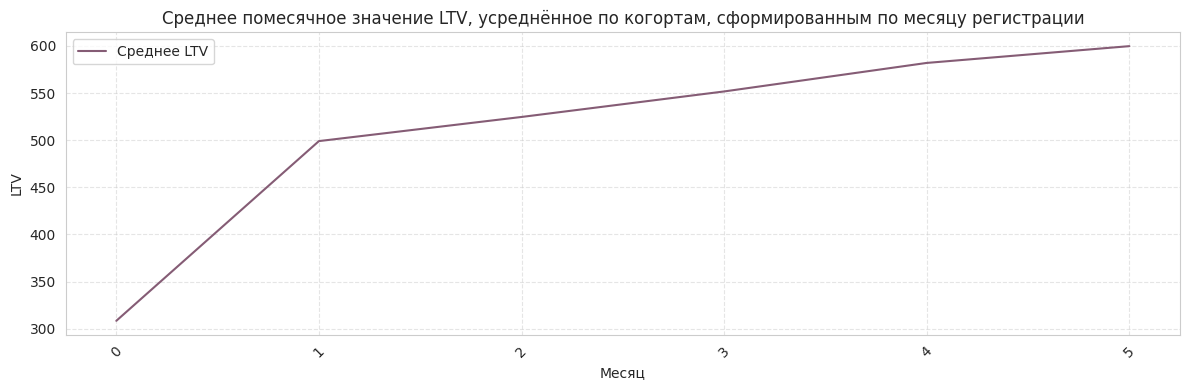

In [224]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(ltv_df.index, ltv_df['LTV_avg'], label='Среднее LTV')

ax.set_xticks(ltv_df.index)
ax.set_xticklabels(ltv_df.index, rotation=45)

plt.title('Среднее помесячное значение LTV, усреднённое по когортам, сформированным по месяцу регистрации')
plt.ylabel('LTV')
plt.xlabel('Месяц')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()

Посмотрим сколько в среднем у пользователя уходит времени от регестрации до первой покупки

In [229]:
retention = df_pp_success.copy()
retention['row'] = retention.sort_values('created_at').groupby('user_id').cumcount() + 1
retention = pd.merge(df_users, retention, how='inner', on='user_id')

In [232]:
retention = retention[retention['row'] == 1]

In [233]:
retention['difference'] = (retention['created_at_y'] - retention['created_at_x']).dt.days

<ipython-input-233-ec78045c68f5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [247]:
pec = np.percentile(retention['difference'], 95)

In [248]:
dift_mean = retention.query('difference < @pec')['difference']

<Axes: >

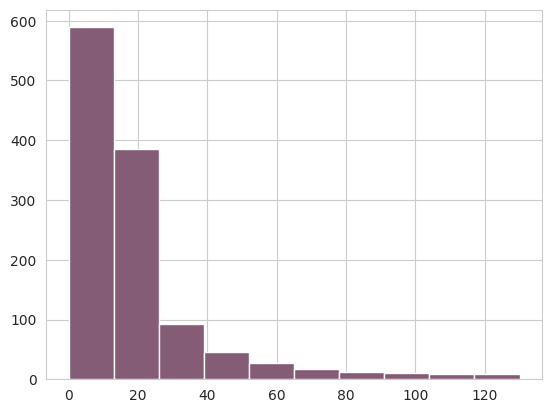

In [253]:
dift_mean.hist()

In [249]:
dift_mean.mean()

np.float64(16.814691151919867)



**Базовые тарифы** работают хорошо: привлекательная цена, простота, один виджет.

**Продвинутые тарифы (Medium, Expert)** продаются значительно хуже — скорее всего из-за отсутствия заметных преимуществ, кроме количества виджетов.

Необходимо рассмотреть возможность **добавления полезного функционала** в Medium и Expert, чтобы повысить их ценность и конверсию.

### Возможные идеи для улучшения тарифов:

| Тариф  | Идеи по улучшению |
|--------|-------------------|
| **Medium** | - Уведомления о новых отзывах  <br> - Ежедневное обновление отзывов  <br> - Расширенная поддержка |
| **Expert** | - Возможность добавления собственных филиалов для сбора отзывов  <br> - ИИ-перевод отзывов  <br> - Обновление отзывов в реальном времени  <br> - Расширенная поддержка |

Также можно рассмотреть добавление **аналитики по отзывам**, но перед этим стоит провести **опрос пользователей** для выявления наиболее нужного функционала.

---

## О тестировании изменений

Если рассматривать среднемесячную **конверсию из регистрации в первую покупку** продвинутых тарифов среди пользователей, зарегистрировавшихся в 2024 году, то:
- Тарифы **Expert — 1 год** и **Expert — 3 месяца** были выбраны **всего один раз** в качестве первой покупки после регестрации.
- Тариф **Medium - 3 мес** был приобретён 9 раз в качестве первой покупки.
- Для тарифа **Medium — 1 год** среднемесячная конверсия составила примерно **1%**.

за 2024 год было совершено 990 успешных покупок. Или в процентном соотношении по тарифам:

| №  | Тариф           | Количество покупок | Процент   |
|----|------------------|--------------------|-----------|
| 0  | Expert - 1 год   | 18                 | 1.818%    |
| 1  | Expert - 3 мес   | 7                  | 0.707%    |
| 2  | Medium - 1 год   | 61                 | 6.162%    |
| 3  | Medium - 3 мес   | 35                 | 3.535%    |
| 4  | Start - 1 год    | 575                | 58.081%   |
| 5  | Start - 3 мес    | 294                | 29.697%   |


Вполне возможно, что проведение A/B-тестирования может занять много времени и дорого обойтись.

### Возможные подходы:

- Внести улучшения сразу, отобрав наиболее полезные и недорогие в реализации идеи.
- Параллельно провести **опрос пользователей** или проанализировать **обращения в поддержку**, чтобы приоритизировать функционал.


Для сравнения: среднемесячная конверсия из регистрации в первую покупку для тарифа Start (1 год) в 2024 году составила около 17%, а для тарифа Start (3 месяца) — около 6%. Речь идет о конверсии пользователей, зарегистрировавшихся в данном месяце, с учетом их активности до последней доступной даты.

В среднем в месяц регистрируется около 145 новых пользователей.

Если взять средний ARPU (доход на пользователя) для месячной когорты, то:

На второй месяц жизни пользователя приходится ~500 рублей выручки.

К шестому месяцу этот показатель вырастает до ~600 рублей.

Время до первой покупки:
У большинства пользователей первая покупка происходит в течение 0–20 дней после регистрации, в среднем — ~17 дней.

